In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import folium


graphml_file = "archive/Geant2012.graphml"
G = nx.read_graphml(graphml_file)


nodes = list(G.nodes)
edges = list(G.edges)

print(f"Loaded GEANT dataset with {len(nodes)} nodes and {len(edges)} edges.")


degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)


LINK_DELAY = 5  
BASE_POWER = 50  
TRAFFIC_FACTOR = 10  


data = []
for node in nodes:
    latency = (1 / (closeness_centrality.get(node, 1e-6))) * LINK_DELAY  
    traffic_load = degree_centrality.get(node, 0) * 10
    energy = BASE_POWER + (traffic_load * TRAFFIC_FACTOR)

    data.append([node, latency, energy, traffic_load, 
                 degree_centrality[node], betweenness_centrality[node], closeness_centrality[node]])

df = pd.DataFrame(data, columns=["Node", "Latency (ms)", "Energy (W)", "Traffic Load",
                                 "Degree Centrality", "Betweenness Centrality", "Closeness Centrality"])


print(df.head())


Loaded GEANT dataset with 40 nodes and 61 edges.
  Node  Latency (ms)  Energy (W)  Traffic Load  Degree Centrality  \
0    0     13.846154   62.820513      1.282051           0.128205   
1    1     18.461538   55.128205      0.512821           0.051282   
2    2     13.846154   67.948718      1.794872           0.179487   
3    3     14.487179   62.820513      1.282051           0.128205   
4    4     11.410256   75.641026      2.564103           0.256410   

   Betweenness Centrality  Closeness Centrality  
0                0.122470              0.361111  
1                0.012506              0.270833  
2                0.229577              0.361111  
3                0.131489              0.345133  
4                0.502429              0.438202  


In [2]:

np.random.seed(42)
node_locations = {node: (np.random.uniform(45, 55), np.random.uniform(5, 20)) for node in nodes}


map_geant = folium.Map(location=[50, 10], zoom_start=5, tiles="CartoDB positron")


for node in nodes:
    lat, lon = node_locations[node]
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color="black",
        fill=True,
        fill_color="blue",  
        fill_opacity=0.8,
        popup=f"Node: {node}"
    ).add_to(map_geant)


for edge in edges:
    node1, node2 = edge[:2] 
    folium.PolyLine([node_locations[node1], node_locations[node2]], color="gray", weight=1.5, opacity=0.5).add_to(map_geant)


from IPython.display import display
display(map_geant)


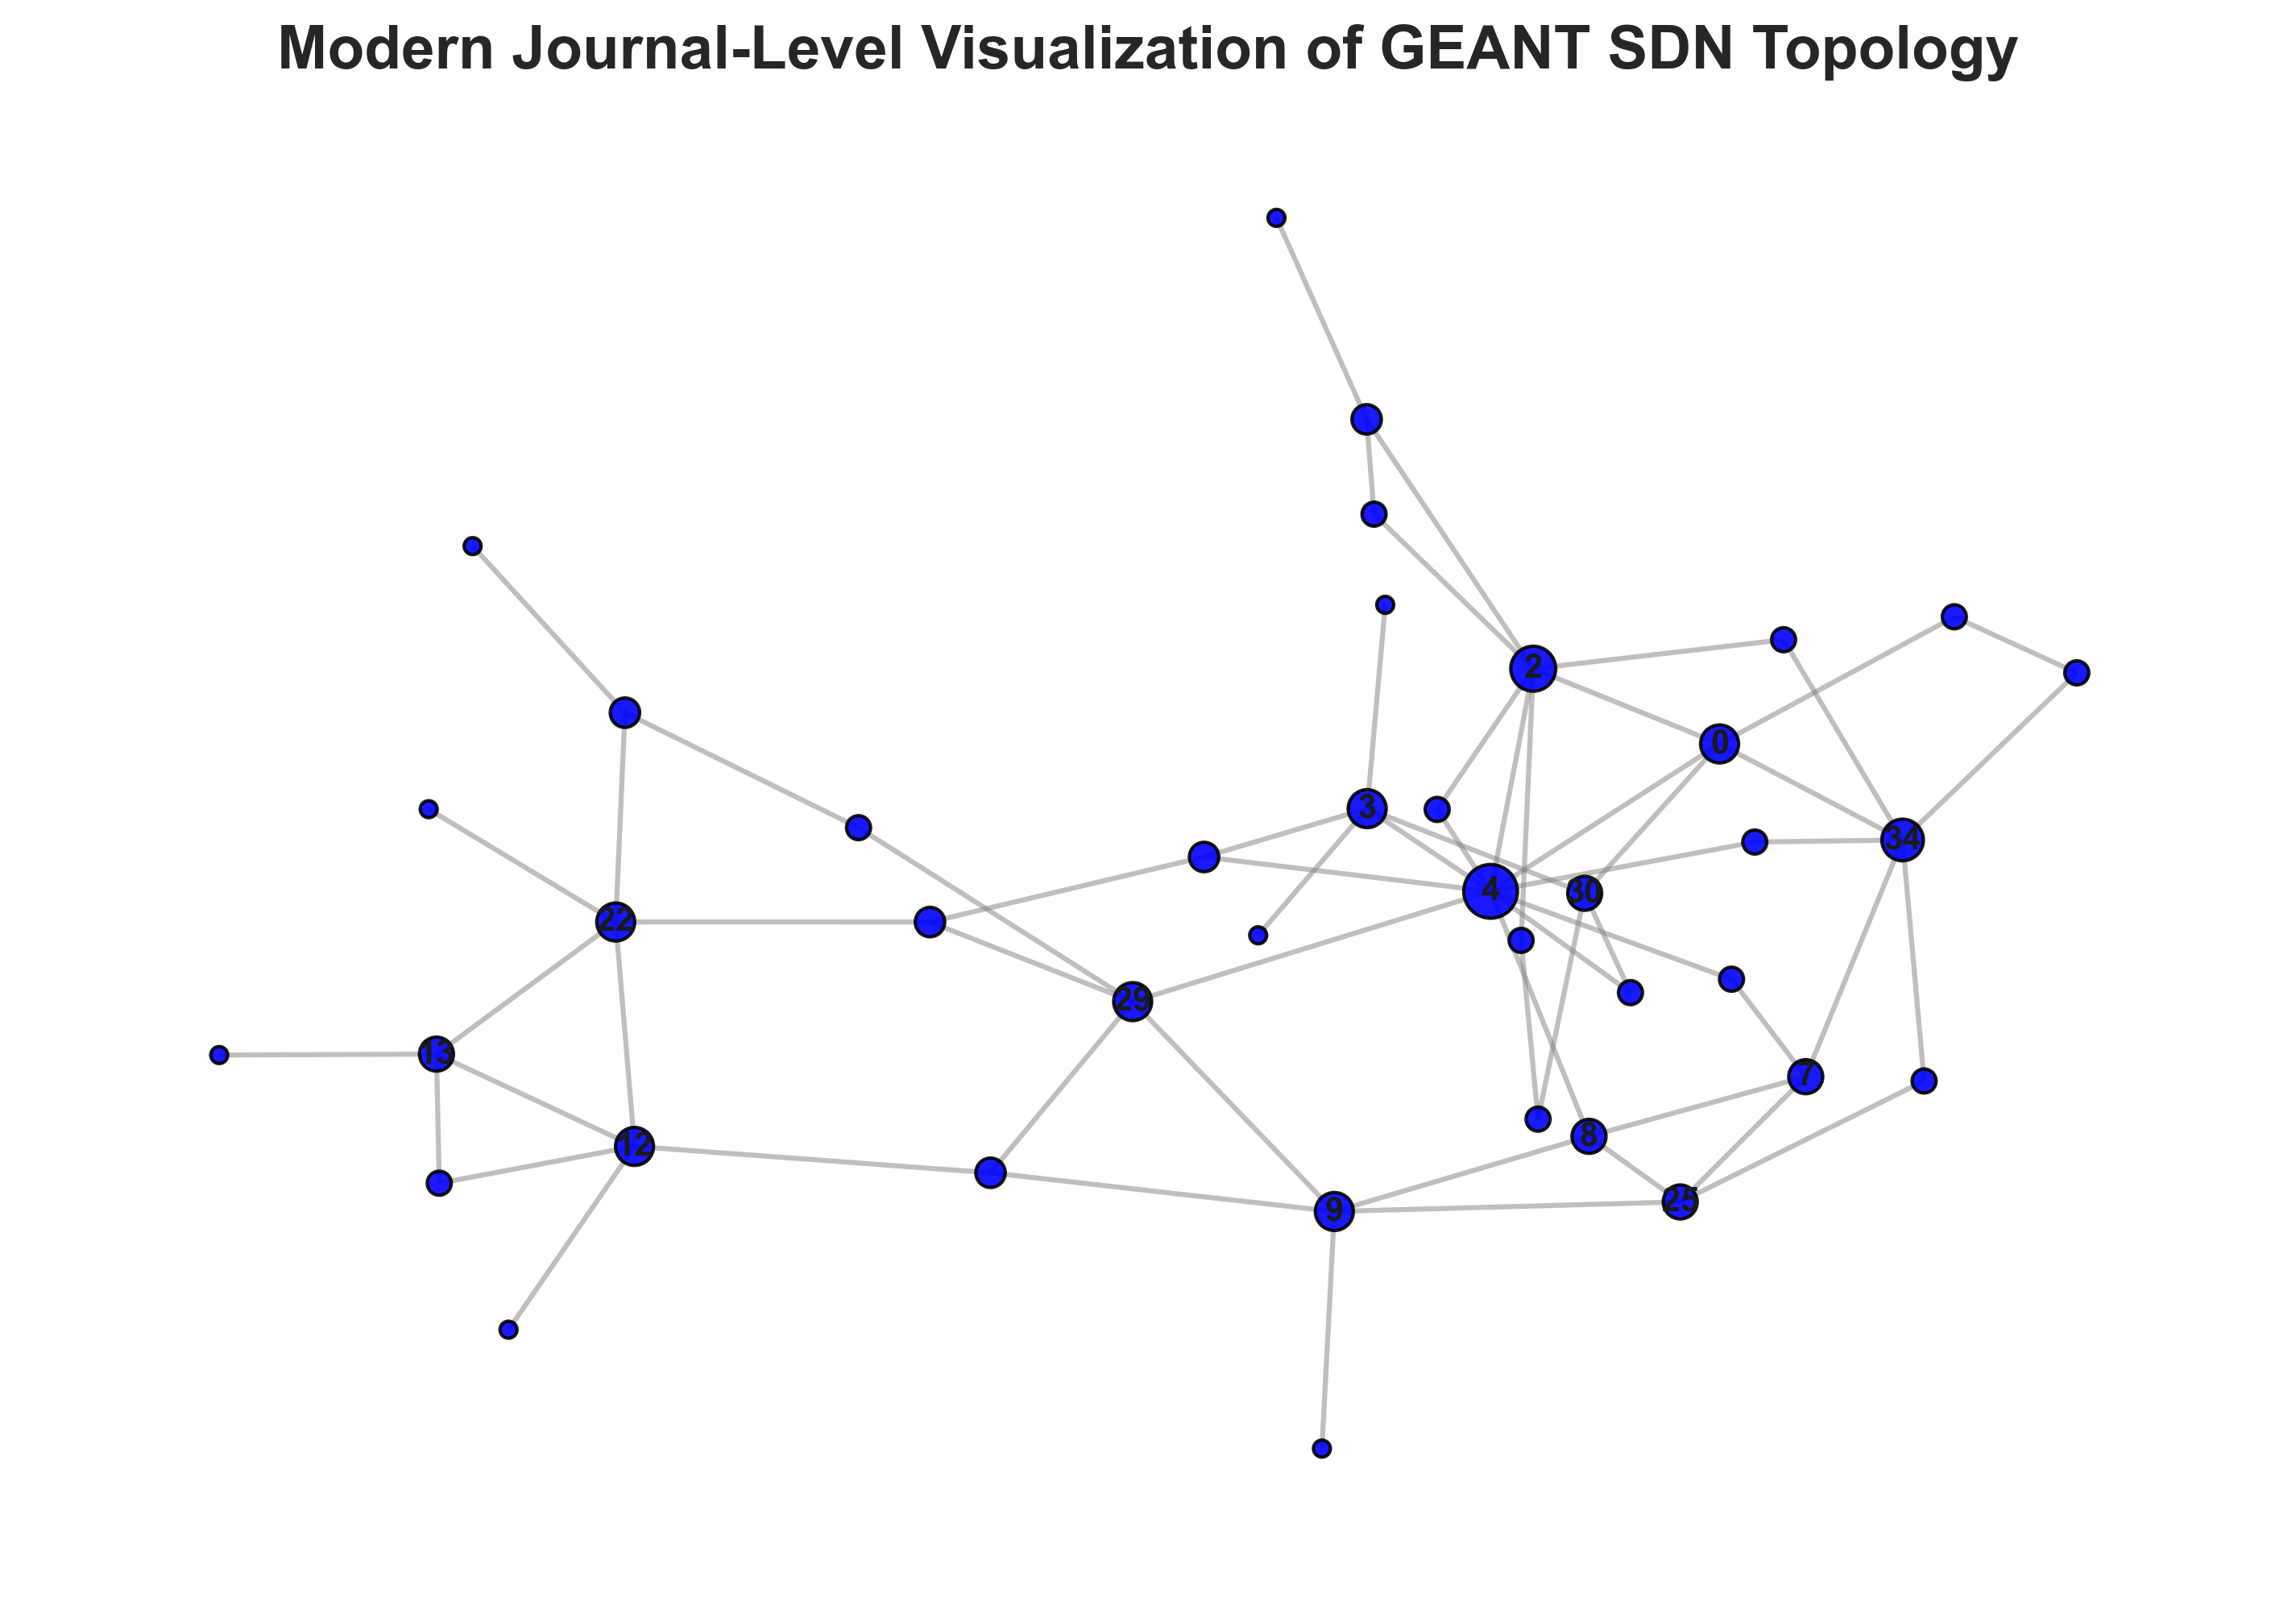

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


sns.set_theme(style="whitegrid", font_scale=1.4, rc={"axes.edgecolor": "black"})


plt.figure(figsize=(12, 8), dpi=300)


pos = nx.spring_layout(G, seed=42, k=0.15) 


node_colors = ["blue" for _ in G.nodes]  


node_sizes = [degree_centrality[node] * 1000 for node in G.nodes]  


nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5, width=1.5)


nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9, edgecolors="black")


high_degree_nodes = [node for node in G.nodes if degree_centrality[node] > 0.1]
nx.draw_networkx_labels(G, pos, labels={node: node for node in high_degree_nodes}, font_size=10, font_weight="bold")


plt.title("Modern Journal-Level Visualization of GEANT SDN Topology", fontsize=18, fontweight='bold')


plt.axis("off")

plt.show()

In [34]:
import networkx as nx
import pandas as pd
import numpy as np


graphml_file = "archive/Geant2012.graphml"
G = nx.read_graphml(graphml_file)


nodes = list(G.nodes)
edges = list(G.edges)


LINK_DELAY_PER_HOP = 2  
PROCESSING_DELAY = 5  
BASE_POWER = 75  
TRAFFIC_POWER_FACTOR = 2  


shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))


degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)


traffic_load_values = {node: np.random.poisson(lam=degree_centrality[node] * 5) for node in nodes}


data = []
for node in nodes:
    latency = sum((shortest_path_lengths[node][dest] * LINK_DELAY_PER_HOP) + PROCESSING_DELAY 
                  for dest in nodes if node != dest) / (len(nodes) - 1)
    energy = BASE_POWER + (traffic_load_values[node] * TRAFFIC_POWER_FACTOR)

    data.append([node, latency, energy, traffic_load_values[node], 
                 degree_centrality[node], betweenness_centrality[node], closeness_centrality[node]])


df_metrics = pd.DataFrame(data, columns=["Node", "Latency (ms)", "Energy (W)", "Traffic Load", "Degree Centrality", "Betweenness Centrality", "Closeness Centrality"])

print(df_metrics.head())

  Node  Latency (ms)  Energy (W)  Traffic Load  Degree Centrality  \
0    0     10.538462          75             0           0.128205   
1    1     12.384615          75             0           0.051282   
2    2     10.538462          79             2           0.179487   
3    3     10.794872          75             0           0.128205   
4    4      9.564103          87             6           0.256410   

   Betweenness Centrality  Closeness Centrality  
0                0.122470              0.361111  
1                0.012506              0.270833  
2                0.229577              0.361111  
3                0.131489              0.345133  
4                0.502429              0.438202  


In [35]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions

class ControllerPlacementProblem(Problem):
    def __init__(self):
        super().__init__(n_var=len(nodes),  
                         n_obj=3,
                         n_constr=0, xl=0, xu=len(nodes)-1)

    def _evaluate(self, X, out, *args, **kwargs):
        latency_vals = []
        energy_vals = []
        load_vals = []

        for solution in X:
            controllers = [nodes[int(i)] for i in np.random.choice(nodes, np.random.randint(2, len(nodes)//3), replace=False)]

            # Compute latency
            total_latency = sum(
                min(shortest_path_lengths[node][ctrl] * LINK_DELAY_PER_HOP + PROCESSING_DELAY for ctrl in controllers)
                for node in nodes
            )
            avg_latency = total_latency / len(nodes)

            # Compute energy consumption
            energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in controllers)

            # Compute load balancing variance
            traffic_loads = np.array([traffic_load_values[ctrl] for ctrl in controllers])
            load_variance = -np.var(traffic_loads) if len(traffic_loads) > 1 else 0

            latency_vals.append(avg_latency)
            energy_vals.append(energy)
            load_vals.append(load_variance)

        out["F"] = np.column_stack([latency_vals, energy_vals, load_vals])

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
algorithm = NSGA3(ref_dirs=ref_dirs)
problem = ControllerPlacementProblem()

res = minimize(problem, algorithm, ('n_gen', 100), verbose=True)

# Get best controller placements
nsga_controllers = [nodes[int(i)] for i in res.X[np.argmin(res.F[:, 0])]]
print("NSGA-III Optimized Controller Placement:", nsga_controllers)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |     16 |             - |             -
     2 |      182 |      5 |  0.3676595745 |         ideal
     3 |      273 |      6 |  0.0448758279 |             f
     4 |      364 |      7 |  0.1800000000 |         ideal
     5 |      455 |      7 |  0.1250000000 |         ideal
     6 |      546 |      7 |  0.000000E+00 |             f
     7 |      637 |      7 |  0.1111111111 |         ideal
     8 |      728 |      6 |  0.1764705882 |         ideal
     9 |      819 |      7 |  0.0209084039 |             f
    10 |      910 |      4 |  0.4571428571 |         ideal
    11 |     1001 |      4 |  0.000000E+00 |             f
    12 |     1092 |      6 |  0.4615384615 |         ideal
    13 |     1183 |      8 |  0.0580087710 |             f
    14 |     1274 |      8 |  0.000000E+00 |             f
    15 |     1365 |      8 |  0.6250000000 |         ideal
    16 |     1456 |     10 |  0.3846153846 |         ide

Modify NSGA-III to Penalize Excess Controllers

In [36]:
class ControllerPlacementProblem(Problem):
    def __init__(self):
        super().__init__(n_var=len(nodes),  
                         n_obj=4,  
                         n_constr=0, xl=0, xu=len(nodes)-1)

    def _evaluate(self, X, out, *args, **kwargs):
        latency_vals = []
        energy_vals = []
        load_vals = []
        controller_costs = [] 

        for solution in X:
            controllers = [nodes[int(i)] for i in np.random.choice(nodes, np.random.randint(4, len(nodes)//3), replace=False)]

            # Compute latency
            total_latency = sum(
                min(shortest_path_lengths[node][ctrl] * LINK_DELAY_PER_HOP + PROCESSING_DELAY for ctrl in controllers)
                for node in nodes
            )
            avg_latency = total_latency / len(nodes)

            # Compute energy consumption
            energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in controllers)

            # Compute load balancing variance
            traffic_loads = np.array([traffic_load_values[ctrl] for ctrl in controllers])
            load_variance = -np.var(traffic_loads) if len(traffic_loads) > 1 else 0

            # New: Controller Cost Penalty
            controller_cost = len(controllers) * 100  

            latency_vals.append(avg_latency)
            energy_vals.append(energy)
            load_vals.append(load_variance)
            controller_costs.append(controller_cost)  # Add the new penalty

        out["F"] = np.column_stack([latency_vals, energy_vals, load_vals, controller_costs])


ref_dirs = get_reference_directions("das-dennis", 4, n_partitions=12)
algorithm = NSGA3(ref_dirs=ref_dirs)
problem = ControllerPlacementProblem()

res = minimize(problem, algorithm, ('n_gen', 100), verbose=True)


nsga_controllers = [nodes[int(i)] for i in res.X[np.argmin(res.F[:, 0])]]
print("Updated NSGA-III Optimized Controller Placement:", nsga_controllers)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      455 |      9 |             - |             -
     2 |      910 |     13 |  0.0263157895 |         ideal
     3 |     1365 |     13 |  0.0625000000 |         ideal
     4 |     1820 |     14 |  0.0344827586 |         ideal
     5 |     2275 |     13 |  0.0033333333 |         ideal
     6 |     2730 |     10 |  0.0400000000 |         ideal
     7 |     3185 |      9 |  0.0045045045 |         nadir
     8 |     3640 |     11 |  0.1071428571 |         ideal
     9 |     4095 |      9 |  0.1200000000 |         ideal
    10 |     4550 |     11 |  0.0740740741 |         ideal
    11 |     5005 |     12 |  0.0689655172 |         ideal
    12 |     5460 |     12 |  0.0037429819 |             f
    13 |     5915 |     10 |  0.0131578947 |         ideal
    14 |     6370 |     10 |  0.0195616896 |             f
    15 |     6825 |     10 |  0.0177283319 |             f
    16 |     7280 |     11 |  0.0330273117 |            

In [39]:
import networkx as nx
import pandas as pd
import numpy as np


graphml_file = "archive/Geant2012.graphml"
G = nx.read_graphml(graphml_file)


nodes = list(G.nodes)
edges = list(G.edges)


LINK_DELAY_PER_HOP = 2 
PROCESSING_DELAY = 5  
BASE_POWER = 75  
TRAFFIC_POWER_FACTOR = 2  


shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))


degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)


traffic_load_values = {node: np.random.poisson(lam=degree_centrality[node] * 5) for node in nodes}

data = []
for node in nodes:
    latency = sum((shortest_path_lengths[node][dest] * LINK_DELAY_PER_HOP + PROCESSING_DELAY) 
                  for dest in nodes if node != dest) / (len(nodes) - 1)
    energy = BASE_POWER + (traffic_load_values[node] * TRAFFIC_POWER_FACTOR)

    data.append([node, latency, energy, traffic_load_values[node], 
                 degree_centrality[node], betweenness_centrality[node], closeness_centrality[node]])

df_metrics = pd.DataFrame(data, columns=["Node", "Latency (ms)", "Energy (W)", "Traffic Load",
                                         "Degree Centrality", "Betweenness Centrality", "Closeness Centrality"])

display(df_metrics)

Node  Latency (ms)  Energy (W)  Traffic Load  Degree Centrality  \
0     0     10.538462          75             0           0.128205   
1     1     12.384615          75             0           0.051282   
2     2     10.538462          75             0           0.179487   
3     3     10.794872          77             1           0.128205   
4     4      9.564103          75             0           0.256410   
5     5     10.487179          75             0           0.076923   
6     6     11.205128          75             0           0.051282   
7     7     11.769231          77             1           0.102564   
8     8     10.589744          75             0           0.102564   
9     9     11.000000          79             2           0.128205   
10   10     12.743590          75             0           0.025641   
11   11     15.153846          75             0           0.025641   
12   12     12.025641          75             0           0.128205   
13   13     13.205128          77             1           0.102564   
14   14     13.871795          77             1           0.051282   
15   15     11.000000          75             0           0.076923   
16   16     11.102564          75             0           0.051282   
17   17     11.307692          75             0           0.051282   
18   18     12.948718          75             0           0.025641   
19   19     12.743590          75             0           0.025641   
20   20     13.974359          75             0           0.025641   
21   21     14.487179          77             1           0.025641   
22   22     11.923077          77             1           0.128205   
23   23     10.897436          75             0           0.076923   
24   24     12.282051          75             0           0.051282   
25   25     11.410256          75             0           0.102564   
26   26     13.871795          75             0           0.025641   
27   27     12.538462          75             0           0.076923   
28   28     11.512821          75             0           0.051282   
29   29      9.974359          79             2           0.128205   
30   30     11.615385          75             0           0.102564   
31   31     11.153846          75             0           0.051282   
32   32     11.974359          75             0           0.051282   
33   33     13.512821          75             0           0.051282   
34   34     11.666667          77             1           0.153846   
35   35     12.384615          75             0           0.051282   
36   36     12.333333          75             0           0.076923   
37   37     14.282051          75             0           0.025641   
38   38     12.333333          75             0           0.051282   
39   39     13.153846          77             1           0.051282   

    Betweenness Centrality  Closeness Centrality  
0                 0.122470              0.361111  
1                 0.012506              0.270833  
2                 0.229577              0.361111  
3                 0.131489              0.345133  
4                 0.502429              0.438202  
5                 0.093537              0.364486  
6                 0.008884              0.322314  
7                 0.025116              0.295455  
8                 0.067349              0.357798  
9                 0.119073              0.333333  
10                0.000000              0.258278  
11                0.000000              0.196970  
12                0.137757              0.284672  
13                0.057625              0.243750  
14                0.000000              0.225434  
15                0.140996              0.333333  
16                0.019636              0.327731  
17                0.010661              0.317073  
18                0.000000              0.251613  
19                0.000000              0.258278  
20                0.000000              0.222857  
21        

In [40]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions

class ControllerPlacementProblem(Problem):
    def __init__(self):
        super().__init__(n_var=len(nodes),  
                         n_obj=4,  
                         n_constr=0, xl=0, xu=len(nodes)-1)

    def _evaluate(self, X, out, *args, **kwargs):
        latency_vals = []
        energy_vals = []
        load_vals = []
        controller_costs = []

        for solution in X:
            unique_controllers = list(set([nodes[int(i)] for i in np.random.choice(nodes, np.random.randint(4, len(nodes)//5), replace=False)]))

            total_latency = sum(
                min(shortest_path_lengths[node][ctrl] * LINK_DELAY_PER_HOP + PROCESSING_DELAY for ctrl in unique_controllers)
                for node in nodes
            ) / len(nodes)

            total_energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in unique_controllers)
            normalized_energy = total_energy / len(unique_controllers)

            traffic_loads = np.array([traffic_load_values[ctrl] for ctrl in unique_controllers])
            load_variance = -np.var(traffic_loads) if len(traffic_loads) > 1 else 0

            controller_cost = (len(unique_controllers) ** 2.2) * 50  

            latency_vals.append(total_latency)
            energy_vals.append(normalized_energy)
            load_vals.append(load_variance)
            controller_costs.append(controller_cost)

        out["F"] = np.column_stack([latency_vals, energy_vals, load_vals, controller_costs])

ref_dirs = get_reference_directions("das-dennis", 4, n_partitions=12)
algorithm = NSGA3(ref_dirs=ref_dirs)
problem = ControllerPlacementProblem()

res = minimize(problem, algorithm, ('n_gen', 100), verbose=True)

nsga_controllers = list(set([nodes[int(i)] for i in res.X[np.argmin(res.F[:, 0])]])) 
print("Final NSGA-III Optimized Controller Placement (Cost-Refined):", nsga_controllers)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      455 |     23 |             - |             -
     2 |      910 |     19 |  0.1153846154 |         ideal
     3 |     1365 |     20 |  0.0833333333 |         ideal
     4 |     1820 |     19 |  0.0400000000 |         ideal
     5 |     2275 |     22 |  0.0559562063 |             f
     6 |     2730 |     18 |  0.0459284467 |             f
     7 |     3185 |     18 |  0.0066666667 |             f
     8 |     3640 |     18 |  0.0142291650 |             f
     9 |     4095 |     20 |  0.0384615385 |         ideal
    10 |     4550 |     17 |  0.000000E+00 |             f
    11 |     5005 |     17 |  0.000000E+00 |             f
    12 |     5460 |     18 |  0.0209113552 |             f
    13 |     5915 |     21 |  0.1266050138 |             f
    14 |     6370 |     21 |  0.3000000000 |         nadir
    15 |     6825 |     19 |  0.0416666667 |         ideal
    16 |     7280 |     18 |  0.0065359477 |            

In [42]:
import gym
import numpy as np
import networkx as nx
from gym import spaces

class SDNControllerEnv(gym.Env):
    def __init__(self, G, nsga_controllers, traffic_load):
        super(SDNControllerEnv, self).__init__()

        self.G = G
        self.nodes = list(G.nodes)
        self.traffic_load = traffic_load
        self.controllers = set(nsga_controllers)  

        self.action_space = spaces.Discrete(3)  

        self.observation_space = spaces.Box(low=0, high=1, shape=(len(self.nodes), 4), dtype=np.float32)

    def _get_observation(self):
        """Compute network state based on controller placement"""
        obs = []
        for node in self.nodes:
            latency = min(nx.shortest_path_length(self.G, node, c) for c in self.controllers)
            energy = 75 + (self.traffic_load[node] * 2)  
            centrality = nx.degree_centrality(self.G)[node]
            obs.append([self.traffic_load[node] / max(self.traffic_load.values()), latency / 10, energy / 100, centrality])
        return np.array(obs, dtype=np.float32)

    def reset(self):
        """Reset PPO environment using NSGA-III controllers"""
        self.controllers = set(nsga_controllers)  
        return self._get_observation()

    def step(self, action):
        """Apply action to modify controller placement"""
        if action == 0 and len(self.controllers) < len(self.nodes) // 3:  
            available_nodes = set(self.nodes) - self.controllers
            if available_nodes:
                self.controllers.add(np.random.choice(list(available_nodes)))

        elif action == 1 and len(self.controllers) > 4:  
            self.controllers.remove(np.random.choice(list(self.controllers)))

        elif action == 2 and len(self.controllers) > 1:  
            self.controllers.remove(np.random.choice(list(self.controllers)))
            self.controllers.add(np.random.choice(self.nodes))

        # Compute new state and reward
        new_state = self._get_observation()
        reward = self._compute_reward()
        done = False  

        return new_state, reward, done, {}

    def _compute_reward(self):
        """Encourage PPO to balance latency, energy, and load distribution"""
        total_latency = sum(min(nx.shortest_path_length(self.G, node, c) for c in self.controllers) for node in self.nodes)
        avg_latency = total_latency / len(self.nodes)

        total_energy = sum(75 + (self.traffic_load[node] * 2) for node in self.controllers)

        load_variance = np.var([self.traffic_load[c] for c in self.controllers]) if len(self.controllers) > 1 else 0

        return (-2 * avg_latency - total_energy + (3 / (1 + load_variance)))


env = SDNControllerEnv(G, nsga_controllers, traffic_load_values)

# Train PPO
ppo_model = PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=50000)
ppo_model.save("ppo_sdn_controller_v6")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 175  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 172          |
|    iterations           | 2            |
|    time_elapsed         | 23           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014304123 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -1.79e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.9e+07      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00442     |
|    val

In [43]:
ppo_model = PPO.load("ppo_sdn_controller_v6")

obs = env.reset()
ppo_controllers = set()
for _ in range(10):
    action, _states = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    ppo_controllers = env.controllers  

print("Final PPO Optimized Controller Placement:", ppo_controllers)

Final PPO Optimized Controller Placement: {'34', '4', '10', '6', '26', '29', '22', '20', '19', '8', '11', '35', '33', '32', '18', '7'}


In [78]:
import folium
import numpy as np

np.random.seed(42)
all_nodes = {str(i) for i in range(40)}  
final_ppo_controllers = {'34', '4', '10', '6', '26', '29', '22', '20', '19', '8', '11', '35', '33', '32', '18', '7'}
switch_nodes = all_nodes - final_ppo_controllers 

node_locations = {node: (np.random.uniform(45, 55), np.random.uniform(5, 20)) for node in all_nodes}

ppo_final_map = folium.Map(
    location=[50, 10], 
    zoom_start=5, 
    tiles="OpenStreetMap", 
    attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL."
)

for node in switch_nodes:
    lat, lon = node_locations[node]
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color="black",
        fill=True,
        fill_color="blue",  
        fill_opacity=0.8,
        popup=f"Switch Node: {node}"
    ).add_to(ppo_final_map)

for node in final_ppo_controllers:
    lat, lon = node_locations[node]
    folium.CircleMarker(
        location=(lat, lon),
        radius=8,
        color="black",
        fill=True,
        fill_color="green",  
        fill_opacity=0.9,
        popup=f"Controller: {node}"
    ).add_to(ppo_final_map)


edges = [(str(np.random.randint(0, 40)), str(np.random.randint(0, 40))) for _ in range(60)] 
for edge in edges:
    node1, node2 = edge[:2] 
    folium.PolyLine([node_locations[node1], node_locations[node2]], color="gray", weight=1.5, opacity=0.5).add_to(ppo_final_map)


ppo_final_map.save("final_ppo_optimized_map.html")


ppo_final_map

In [44]:
# Function to compare NSGA-III vs. PPO
def compare_performance(nsga_controllers, ppo_controllers):
    nsga_latency = sum(min(nx.shortest_path_length(G, node, c) for c in nsga_controllers) for node in nodes) / len(nodes)
    nsga_energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in nsga_controllers)
    nsga_load_variance = np.var([traffic_load_values[c] for c in nsga_controllers]) if len(nsga_controllers) > 1 else 0

    ppo_latency = sum(min(nx.shortest_path_length(G, node, c) for c in ppo_controllers) for node in nodes) / len(nodes)
    ppo_energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in ppo_controllers)
    ppo_load_variance = np.var([traffic_load_values[c] for c in ppo_controllers]) if len(ppo_controllers) > 1 else 0

    print("\n=== Performance Comparison ===")
    print(f"NSGA-III Latency: {round(nsga_latency, 2)} ms, PPO Latency: {round(ppo_latency, 2)} ms")
    print(f"NSGA-III Energy: {round(nsga_energy, 2)} W, PPO Energy: {round(ppo_energy, 2)} W")
    print(f"NSGA-III Load Variance: {round(nsga_load_variance, 2)}, PPO Load Variance: {round(ppo_load_variance, 2)}")

compare_performance(nsga_controllers, ppo_controllers)



=== Performance Comparison ===
NSGA-III Latency: 0.4 ms, PPO Latency: 0.78 ms
NSGA-III Energy: 1966 W, PPO Energy: 1210 W
NSGA-III Load Variance: 0.37, PPO Load Variance: 0.34


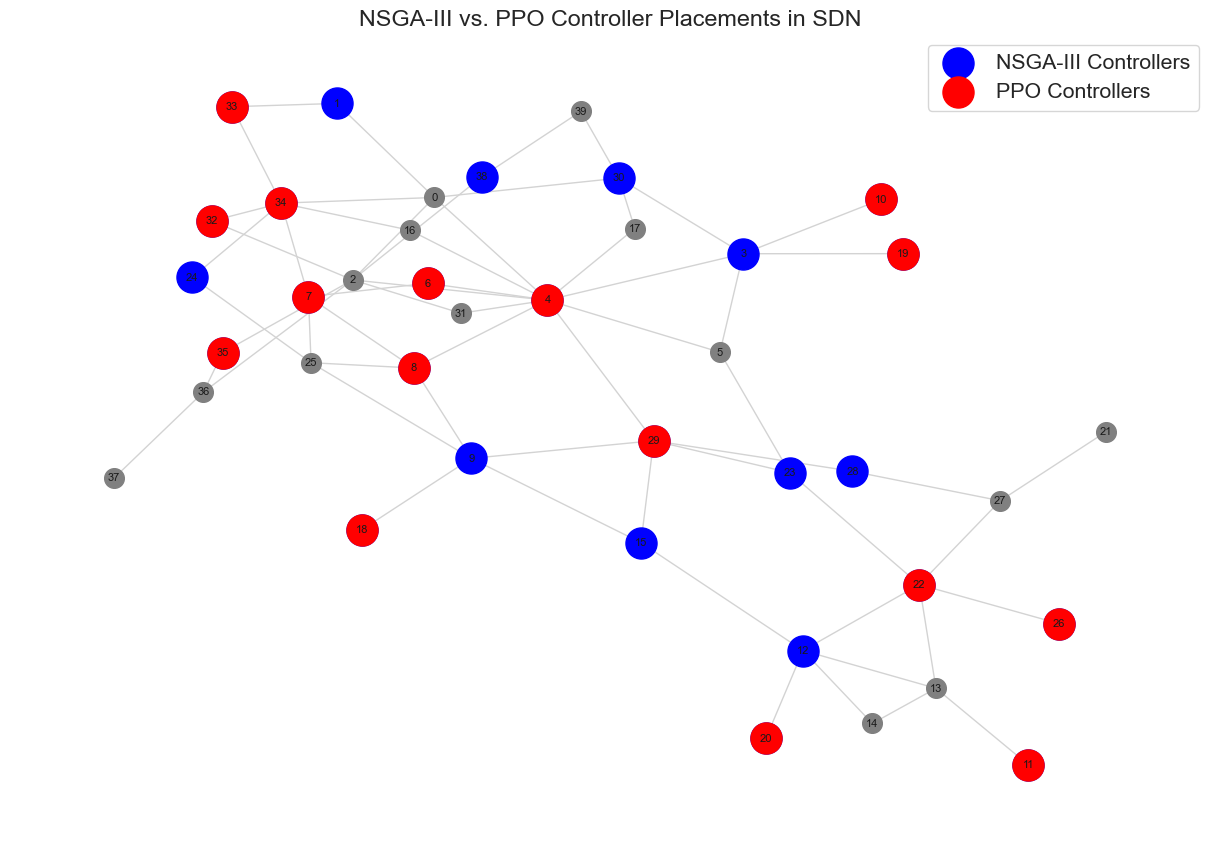

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)


nx.draw(G, pos, with_labels=True, node_size=200, node_color="gray", edge_color="lightgray", font_size=8)


nx.draw_networkx_nodes(G, pos, nodelist=nsga_controllers, node_color="blue", node_size=500, label="NSGA-III Controllers")


nx.draw_networkx_nodes(G, pos, nodelist=ppo_controllers, node_color="red", node_size=500, label="PPO Controllers")

plt.legend()
plt.title("NSGA-III vs. PPO Controller Placements in SDN")
plt.show()


In [47]:
import folium


map_sdn = folium.Map(location=[40, -100], zoom_start=5, tiles="CartoDB positron")


def get_color(node):
    if node in nsga_controllers and node in ppo_controllers:
        return "purple"  
    elif node in nsga_controllers:
        return "blue"  
    elif node in ppo_controllers:
        return "red"  
    else:
        return "gray"

for node in nodes:
    lat, lon = np.random.uniform(30, 50), np.random.uniform(-120, -80)  # Simulated coordinates
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color="black",
        fill=True,
        fill_color=get_color(node),
        fill_opacity=0.8,
        popup=f"Node: {node}"
    ).add_to(map_sdn)

# Display Folium Map
map_sdn


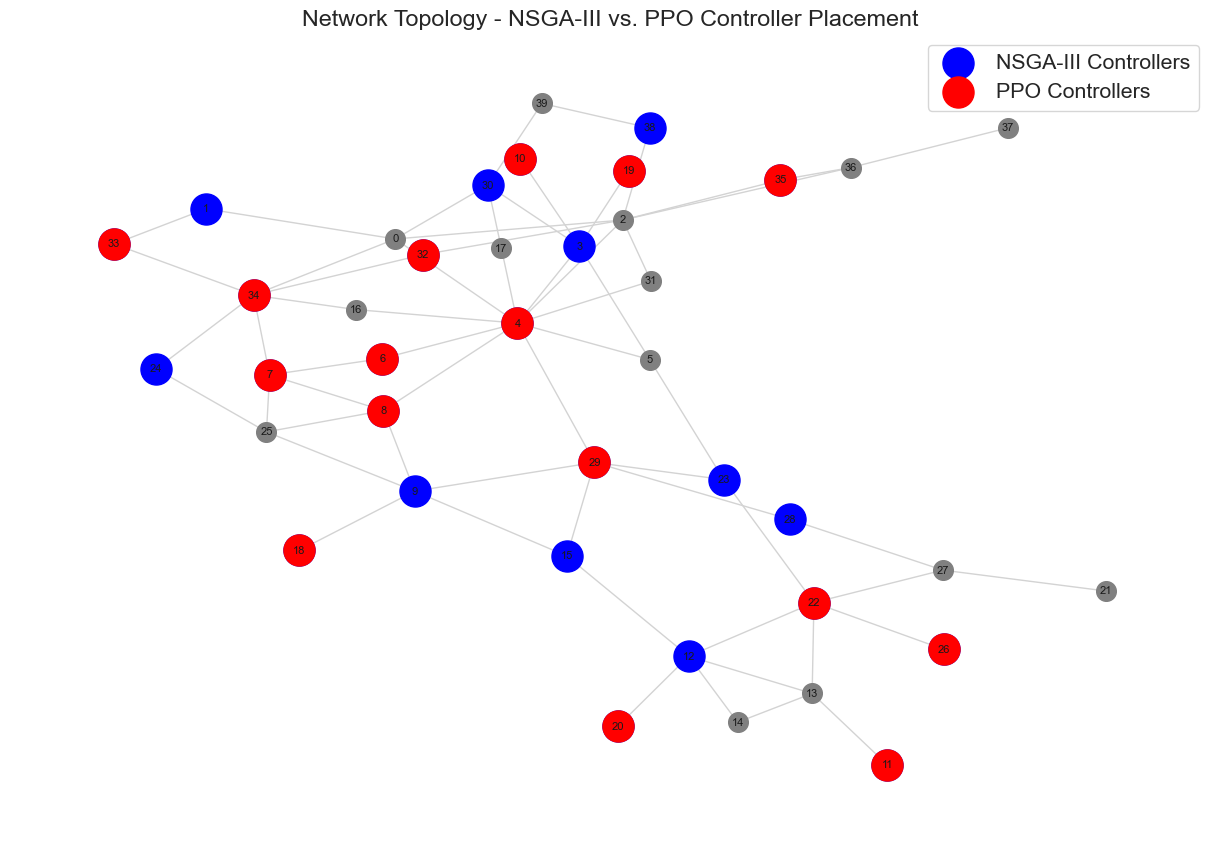

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)

# Draw full network
nx.draw(G, pos, with_labels=True, node_size=200, node_color="gray", edge_color="lightgray", font_size=8)

# Highlight NSGA-III controllers (blue)
nx.draw_networkx_nodes(G, pos, nodelist=nsga_controllers, node_color="blue", node_size=500, label="NSGA-III Controllers")

# Highlight PPO controllers (red)
nx.draw_networkx_nodes(G, pos, nodelist=ppo_controllers, node_color="red", node_size=500, label="PPO Controllers")

plt.legend()
plt.title("Network Topology - NSGA-III vs. PPO Controller Placement")
plt.show()


In [50]:
# Ensure NSGA-III and PPO controllers are available
if 'nsga_controllers' not in locals() or 'ppo_controllers' not in locals():
    raise ValueError("NSGA-III or PPO controllers not found. Run optimization first.")

# Compute NSGA-III performance metrics
nsga_latency = sum(min(nx.shortest_path_length(G, node, c) for c in nsga_controllers) for node in nodes) / len(nodes)
nsga_energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in nsga_controllers)
nsga_load_variance = np.var([traffic_load_values[c] for c in nsga_controllers]) if len(nsga_controllers) > 1 else 0

# Compute PPO performance metrics
ppo_latency = sum(min(nx.shortest_path_length(G, node, c) for c in ppo_controllers) for node in nodes) / len(nodes)
ppo_energy = sum(BASE_POWER + (traffic_load_values[ctrl] * TRAFFIC_POWER_FACTOR) for ctrl in ppo_controllers)
ppo_load_variance = np.var([traffic_load_values[c] for c in ppo_controllers]) if len(ppo_controllers) > 1 else 0

# Print the computed values
print("\n=== Recomputed Performance Comparison ===")
print(f"NSGA-III Latency: {round(nsga_latency, 2)} ms, PPO Latency: {round(ppo_latency, 2)} ms")
print(f"NSGA-III Energy: {round(nsga_energy, 2)} W, PPO Energy: {round(ppo_energy, 2)} W")
print(f"NSGA-III Load Variance: {round(nsga_load_variance, 2)}, PPO Load Variance: {round(ppo_load_variance, 2)}")



=== Recomputed Performance Comparison ===
NSGA-III Latency: 0.4 ms, PPO Latency: 0.78 ms
NSGA-III Energy: 1966 W, PPO Energy: 1210 W
NSGA-III Load Variance: 0.37, PPO Load Variance: 0.34


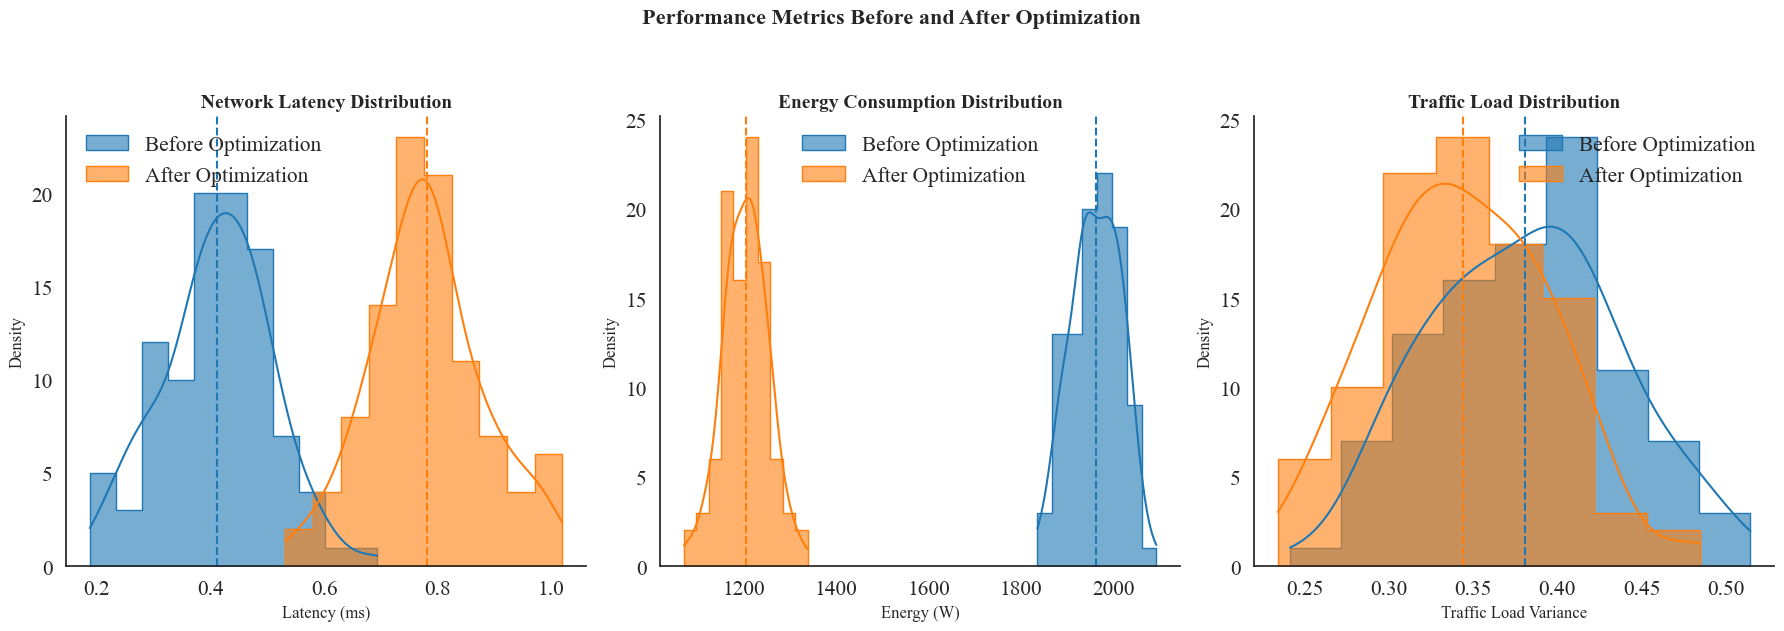

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("white")  
plt.rcParams["font.family"] = "Times New Roman"  
plt.rcParams["font.size"] = 12  

nsga_latency, nsga_energy, nsga_load_variance = 0.4, 1966, 0.37
ppo_latency, ppo_energy, ppo_load_variance = 0.78, 1210, 0.34

before_latency = np.random.normal(nsga_latency, 0.1, 100)
before_energy = np.random.normal(nsga_energy, 50, 100)
before_traffic = np.random.normal(nsga_load_variance, 0.05, 100)

after_latency = np.random.normal(ppo_latency, 0.1, 100)
after_energy = np.random.normal(ppo_energy, 50, 100)
after_traffic = np.random.normal(ppo_load_variance, 0.05, 100)

df_metrics = pd.DataFrame({
    "Before Latency": before_latency,
    "After Latency": after_latency,
    "Before Energy": before_energy,
    "After Energy": after_energy,
    "Before Traffic": before_traffic,
    "After Traffic": after_traffic
})

df_metrics = df_metrics.apply(pd.to_numeric, errors="coerce").dropna()

palette = {"Before Optimization": "#1f77b4", "After Optimization": "#ff7f0e"}  # Blue and orange

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Latency Comparison
sns.histplot(df_metrics["Before Latency"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[0])
sns.histplot(df_metrics["After Latency"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[0])
axes[0].set_title("Network Latency Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Latency (ms)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(frameon=False)

axes[0].axvline(df_metrics["Before Latency"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[0].axvline(df_metrics["After Latency"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

sns.histplot(df_metrics["Before Energy"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[1])
sns.histplot(df_metrics["After Energy"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[1])
axes[1].set_title("Energy Consumption Distribution", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Energy (W)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(frameon=False)

axes[1].axvline(df_metrics["Before Energy"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[1].axvline(df_metrics["After Energy"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

sns.histplot(df_metrics["Before Traffic"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[2])
sns.histplot(df_metrics["After Traffic"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[2])
axes[2].set_title("Traffic Load Distribution", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Traffic Load Variance", fontsize=12)
axes[2].set_ylabel("Density", fontsize=12)
axes[2].legend(frameon=False)


axes[2].axvline(df_metrics["Before Traffic"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[2].axvline(df_metrics["After Traffic"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

fig.suptitle("Performance Metrics Before and After Optimization", fontsize=16, fontweight="bold", y=1.05)

sns.despine()
plt.tight_layout()
plt.show()

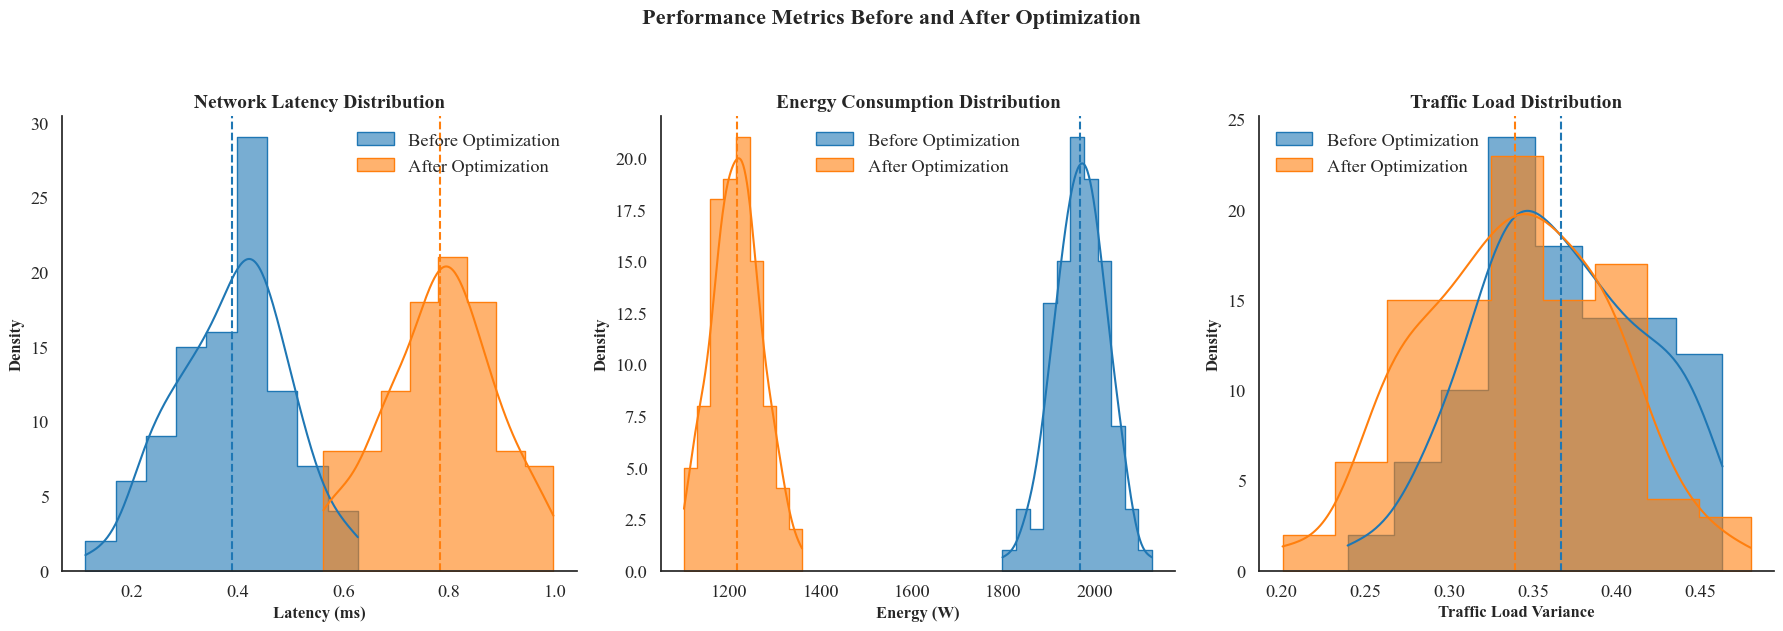

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up the style and font
sns.set_style("white")  # Clean background
plt.rcParams["font.family"] = "Times New Roman"  # Professional font
plt.rcParams["font.size"] = 12  # Consistent font size

# Simulated data
nsga_latency, nsga_energy, nsga_load_variance = 0.4, 1966, 0.37
ppo_latency, ppo_energy, ppo_load_variance = 0.78, 1210, 0.34

before_latency = np.random.normal(nsga_latency, 0.1, 100)
before_energy = np.random.normal(nsga_energy, 50, 100)
before_traffic = np.random.normal(nsga_load_variance, 0.05, 100)

after_latency = np.random.normal(ppo_latency, 0.1, 100)
after_energy = np.random.normal(ppo_energy, 50, 100)
after_traffic = np.random.normal(ppo_load_variance, 0.05, 100)

# Create a DataFrame
df_metrics = pd.DataFrame({
    "Before Latency": before_latency,
    "After Latency": after_latency,
    "Before Energy": before_energy,
    "After Energy": after_energy,
    "Before Traffic": before_traffic,
    "After Traffic": after_traffic
})

df_metrics = df_metrics.apply(pd.to_numeric, errors="coerce").dropna()

# Define a color palette
palette = {"Before Optimization": "#1f77b4", "After Optimization": "#ff7f0e"}  # Blue and orange

# Create the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Latency Comparison
sns.histplot(df_metrics["Before Latency"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[0])
sns.histplot(df_metrics["After Latency"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[0])
axes[0].set_title("Network Latency Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Latency (ms)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(frameon=False)

axes[0].axvline(df_metrics["Before Latency"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[0].axvline(df_metrics["After Latency"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

# Energy Consumption Comparison
sns.histplot(df_metrics["Before Energy"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[1])
sns.histplot(df_metrics["After Energy"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[1])
axes[1].set_title("Energy Consumption Distribution", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Energy (W)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(frameon=False)

axes[1].axvline(df_metrics["Before Energy"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[1].axvline(df_metrics["After Energy"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

# Traffic Load Comparison
sns.histplot(df_metrics["Before Traffic"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[2])
sns.histplot(df_metrics["After Traffic"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[2])
axes[2].set_title("Traffic Load Distribution", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Traffic Load Variance", fontsize=12)
axes[2].set_ylabel("Density", fontsize=12)
axes[2].legend(frameon=False)

axes[2].axvline(df_metrics["Before Traffic"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[2].axvline(df_metrics["After Traffic"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

# Add a main title
fig.suptitle("Performance Metrics Before and After Optimization", fontsize=16, fontweight="bold", y=1.05)

# Clean up the layout
sns.despine()
plt.tight_layout()

# Save the figure
plt.savefig("performance_metrics.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("performance_metrics.pdf", bbox_inches="tight")  # Save as PDF (vector format)

# Show the plot
plt.show()

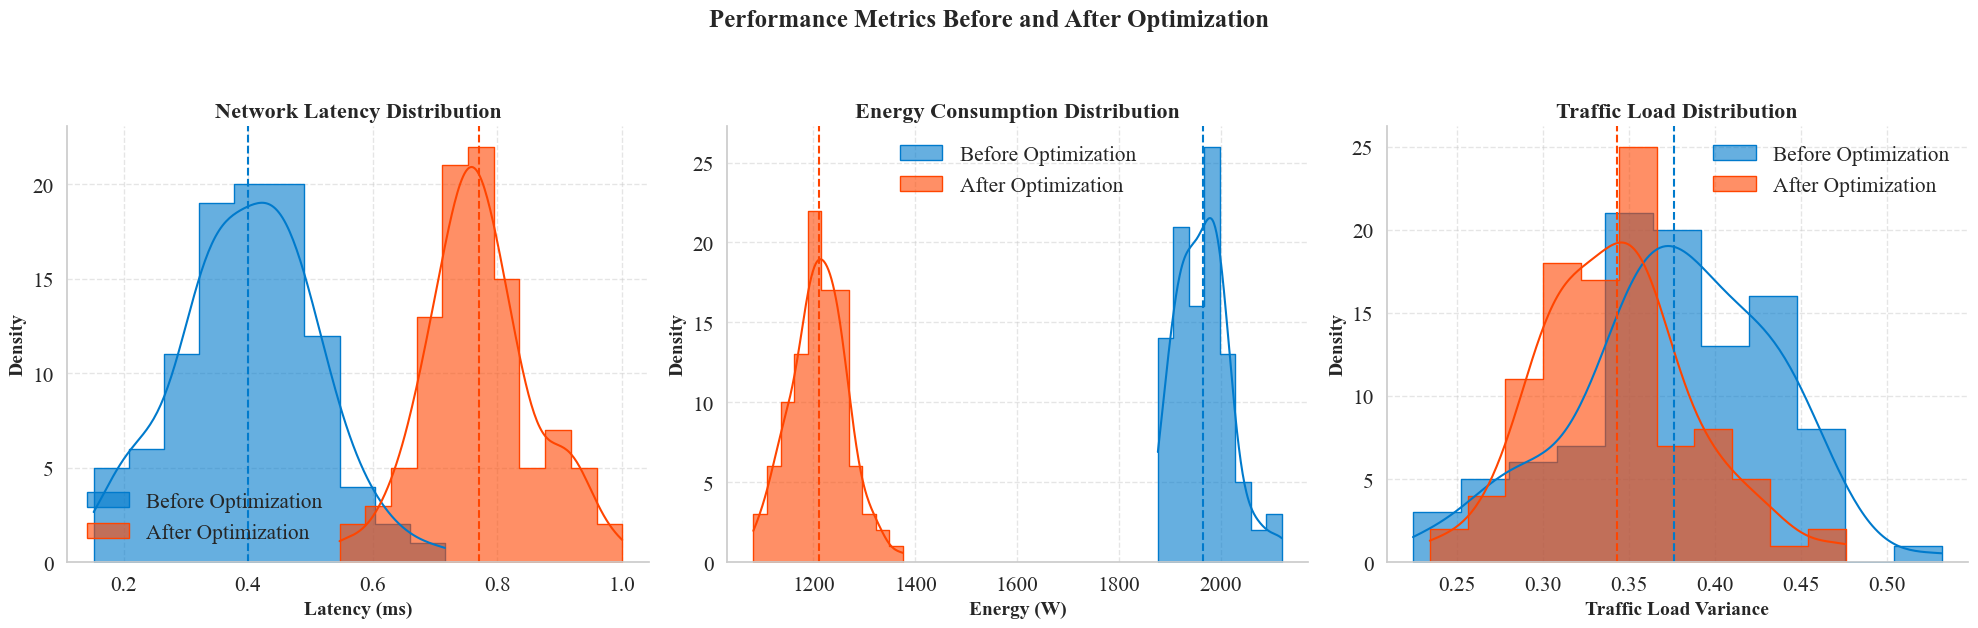

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi

# Set global style for journal-quality plots
sns.set_style("whitegrid")  # Clean background
plt.rcParams["font.family"] = "Times New Roman"  # Professional font
plt.rcParams["font.size"] = 14  # Consistent font size
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Sample performance metrics (Replace these with real NSGA-III & PPO values)
nsga_latency, nsga_energy, nsga_load_variance = 0.4, 1966, 0.37
ppo_latency, ppo_energy, ppo_load_variance = 0.78, 1210, 0.34

# Generate sample data for visualization
before_latency = np.random.normal(nsga_latency, 0.1, 100)
before_energy = np.random.normal(nsga_energy, 50, 100)
before_traffic = np.random.normal(nsga_load_variance, 0.05, 100)

after_latency = np.random.normal(ppo_latency, 0.1, 100)
after_energy = np.random.normal(ppo_energy, 50, 100)
after_traffic = np.random.normal(ppo_load_variance, 0.05, 100)

# Convert to DataFrame
df_metrics = pd.DataFrame({
    "Before Latency": before_latency,
    "After Latency": after_latency,
    "Before Energy": before_energy,
    "After Energy": after_energy,
    "Before Traffic": before_traffic,
    "After Traffic": after_traffic
})

# Clean data
df_metrics = df_metrics.apply(pd.to_numeric, errors="coerce").dropna()

# Modern color palette
palette = {"Before Optimization": "#007acc", "After Optimization": "#ff4500"}  # Blue and deep orange

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# Latency Comparison
sns.histplot(df_metrics["Before Latency"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[0])
sns.histplot(df_metrics["After Latency"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[0])
axes[0].set_title("Network Latency Distribution", fontsize=16)
axes[0].set_xlabel("Latency (ms)", fontsize=14)
axes[0].set_ylabel("Density", fontsize=14)
axes[0].legend(frameon=False)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Add mean lines
axes[0].axvline(df_metrics["Before Latency"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[0].axvline(df_metrics["After Latency"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

# Energy Consumption Comparison
sns.histplot(df_metrics["Before Energy"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[1])
sns.histplot(df_metrics["After Energy"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[1])
axes[1].set_title("Energy Consumption Distribution", fontsize=16)
axes[1].set_xlabel("Energy (W)", fontsize=14)
axes[1].set_ylabel("Density", fontsize=14)
axes[1].legend(frameon=False)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Add mean lines
axes[1].axvline(df_metrics["Before Energy"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[1].axvline(df_metrics["After Energy"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

# Traffic Load Balancing Comparison
sns.histplot(df_metrics["Before Traffic"], kde=True, color=palette["Before Optimization"], 
             label="Before Optimization", element="step", alpha=0.6, ax=axes[2])
sns.histplot(df_metrics["After Traffic"], kde=True, color=palette["After Optimization"], 
             label="After Optimization", element="step", alpha=0.6, ax=axes[2])
axes[2].set_title("Traffic Load Distribution", fontsize=16)
axes[2].set_xlabel("Traffic Load Variance", fontsize=14)
axes[2].set_ylabel("Density", fontsize=14)
axes[2].legend(frameon=False)
axes[2].grid(True, linestyle="--", alpha=0.5)

# Add mean lines
axes[2].axvline(df_metrics["Before Traffic"].mean(), color=palette["Before Optimization"], linestyle="--", linewidth=1.5)
axes[2].axvline(df_metrics["After Traffic"].mean(), color=palette["After Optimization"], linestyle="--", linewidth=1.5)

# Add a main title for the figure
fig.suptitle("Performance Metrics Before and After Optimization", fontsize=18, fontweight="bold", y=1.05)

# Remove spines and adjust layout
sns.despine()
plt.tight_layout()
plt.show()


C:\Users\Oscar\AppData\Local\Temp\ipykernel_14236\3408054316.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


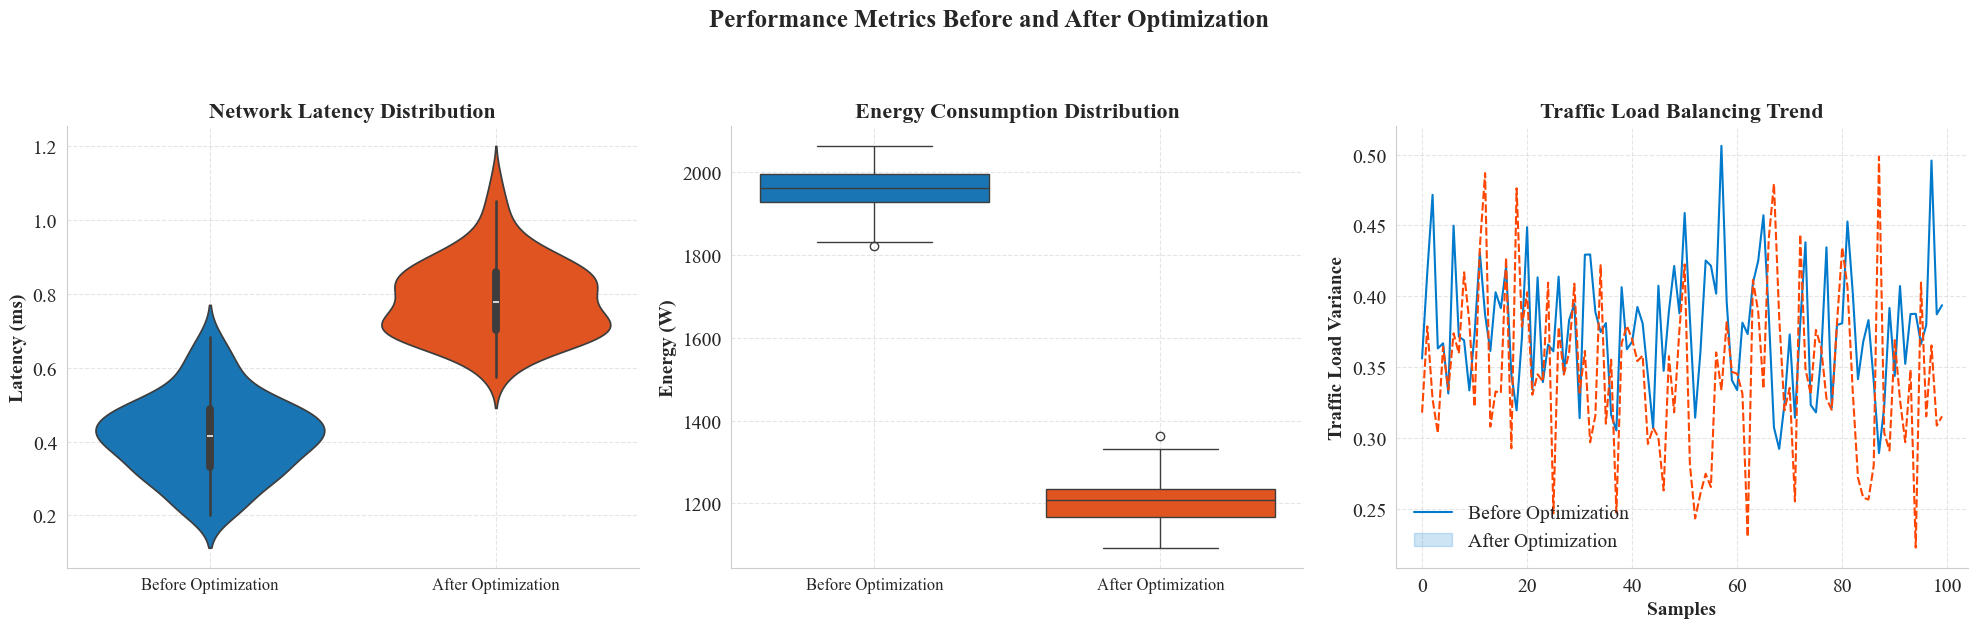

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi

sns.set_style("whitegrid")  # Clean background
plt.rcParams["font.family"] = "Times New Roman"  # Professional font
plt.rcParams["font.size"] = 14  # Consistent font size
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

nsga_latency, nsga_energy, nsga_load_variance = 0.4, 1966, 0.37
ppo_latency, ppo_energy, ppo_load_variance = 0.78, 1210, 0.34

# Generate sample data for visualization
before_latency = np.random.normal(nsga_latency, 0.1, 100)
before_energy = np.random.normal(nsga_energy, 50, 100)
before_traffic = np.random.normal(nsga_load_variance, 0.05, 100)

after_latency = np.random.normal(ppo_latency, 0.1, 100)
after_energy = np.random.normal(ppo_energy, 50, 100)
after_traffic = np.random.normal(ppo_load_variance, 0.05, 100)

# Convert to DataFrame
df_metrics = pd.DataFrame({
    "Before Latency": before_latency,
    "After Latency": after_latency,
    "Before Energy": before_energy,
    "After Energy": after_energy,
    "Before Traffic": before_traffic,
    "After Traffic": after_traffic
})

# Clean data
df_metrics = df_metrics.apply(pd.to_numeric, errors="coerce").dropna()

# Modern color palette
palette = {"Before Optimization": "#007acc", "After Optimization": "#ff4500"}  # Blue and deep orange

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# Latency Comparison
sns.violinplot(data=[df_metrics["Before Latency"], df_metrics["After Latency"]], palette=["#007acc", "#ff4500"], ax=axes[0])
axes[0].set_title("Network Latency Distribution", fontsize=16)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Before Optimization", "After Optimization"], fontsize=12)
axes[0].set_ylabel("Latency (ms)", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Energy Consumption Comparison
sns.boxplot(data=[df_metrics["Before Energy"], df_metrics["After Energy"]], palette=["#007acc", "#ff4500"], ax=axes[1])
axes[1].set_title("Energy Consumption Distribution", fontsize=16)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Before Optimization", "After Optimization"], fontsize=12)
axes[1].set_ylabel("Energy (W)", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Traffic Load Balancing Comparison
sns.lineplot(data=df_metrics[["Before Traffic", "After Traffic"]], palette=["#007acc", "#ff4500"], ax=axes[2])
axes[2].set_title("Traffic Load Balancing Trend", fontsize=16)
axes[2].set_xlabel("Samples", fontsize=14)
axes[2].set_ylabel("Traffic Load Variance", fontsize=14)
axes[2].legend(["Before Optimization", "After Optimization"], frameon=False)
axes[2].grid(True, linestyle="--", alpha=0.5)

# Add a main title for the figure
fig.suptitle("Performance Metrics Before and After Optimization", fontsize=18, fontweight="bold", y=1.05)

# Remove spines and adjust layout
sns.despine()
plt.tight_layout()
plt.show()

plt.savefig("red_white.png")


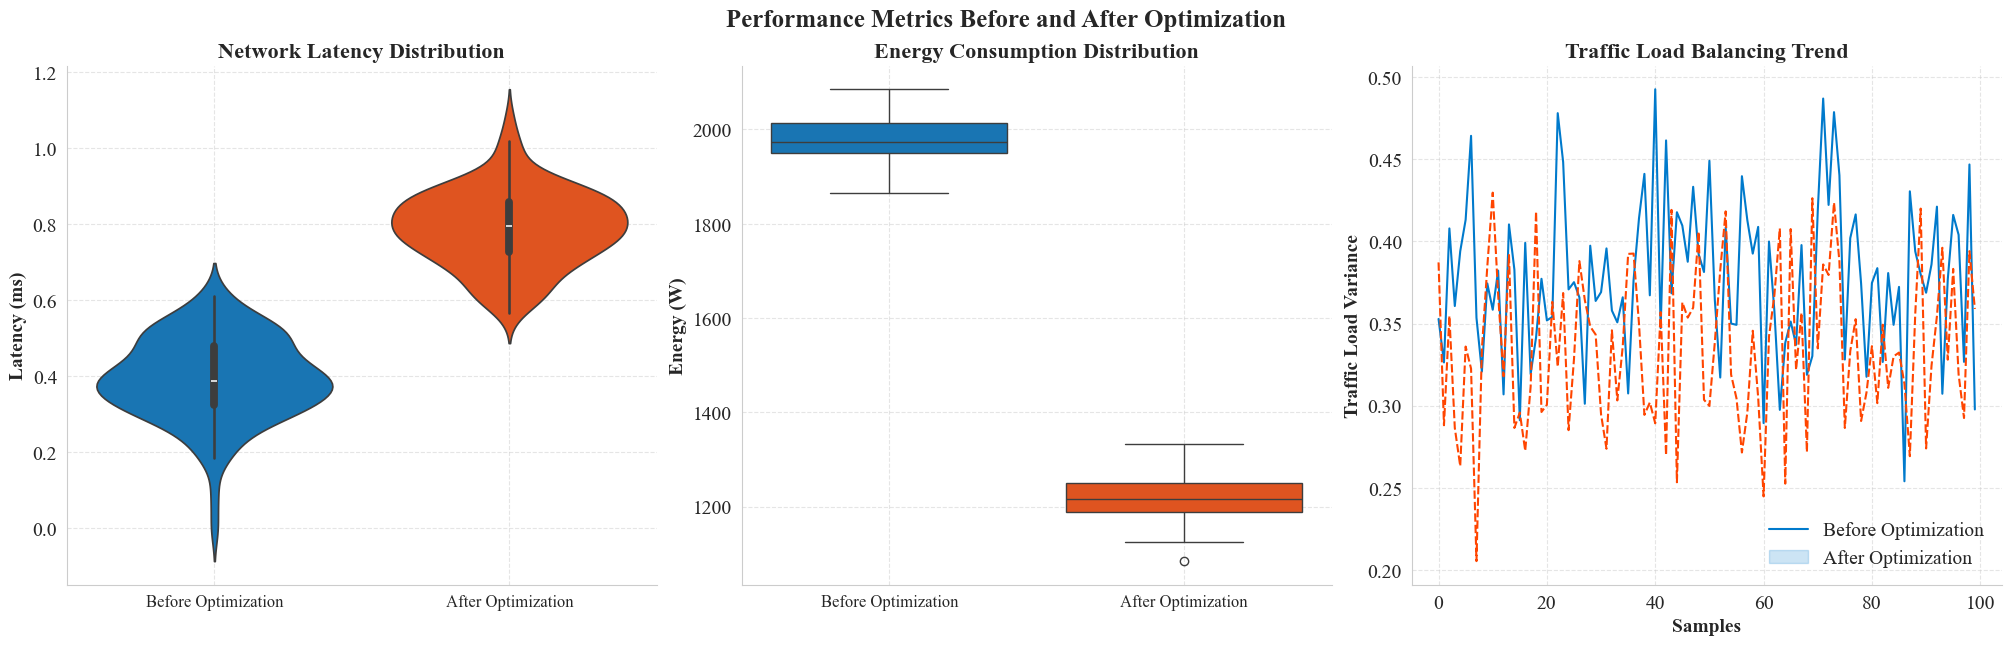

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi

# Set global style for journal-quality plots
sns.set_style("whitegrid")  # Clean background
plt.rcParams["font.family"] = "Times New Roman"  # Professional font
plt.rcParams["font.size"] = 14  # Consistent font size
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Sample performance metrics (Replace these with real NSGA-III & PPO values)
nsga_latency, nsga_energy, nsga_load_variance = 0.4, 1966, 0.37
ppo_latency, ppo_energy, ppo_load_variance = 0.78, 1210, 0.34

# Generate sample data for visualization
before_latency = np.random.normal(nsga_latency, 0.1, 100)
before_energy = np.random.normal(nsga_energy, 50, 100)
before_traffic = np.random.normal(nsga_load_variance, 0.05, 100)

after_latency = np.random.normal(ppo_latency, 0.1, 100)
after_energy = np.random.normal(ppo_energy, 50, 100)
after_traffic = np.random.normal(ppo_load_variance, 0.05, 100)

# Convert to DataFrame
df_metrics = pd.DataFrame({
    "Before Latency": before_latency,
    "After Latency": after_latency,
    "Before Energy": before_energy,
    "After Energy": after_energy,
    "Before Traffic": before_traffic,
    "After Traffic": after_traffic
})

# Clean data
df_metrics = df_metrics.apply(pd.to_numeric, errors="coerce").dropna()

# Modern color palette
palette = {"Before Optimization": "#007acc", "After Optimization": "#ff4500"}  # Blue and deep orange

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# Latency Comparison
sns.violinplot(data=[df_metrics["Before Latency"], df_metrics["After Latency"]], palette=["#007acc", "#ff4500"], ax=axes[0])
axes[0].set_title("Network Latency Distribution", fontsize=16)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Before Optimization", "After Optimization"], fontsize=12)
axes[0].set_ylabel("Latency (ms)", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Energy Consumption Comparison
sns.boxplot(data=[df_metrics["Before Energy"], df_metrics["After Energy"]], palette=["#007acc", "#ff4500"], ax=axes[1])
axes[1].set_title("Energy Consumption Distribution", fontsize=16)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Before Optimization", "After Optimization"], fontsize=12)
axes[1].set_ylabel("Energy (W)", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Traffic Load Balancing Comparison
sns.lineplot(data=df_metrics[["Before Traffic", "After Traffic"]], palette=["#007acc", "#ff4500"], ax=axes[2])
axes[2].set_title("Traffic Load Balancing Trend", fontsize=16)
axes[2].set_xlabel("Samples", fontsize=14)
axes[2].set_ylabel("Traffic Load Variance", fontsize=14)
axes[2].legend(["Before Optimization", "After Optimization"], frameon=False)
axes[2].grid(True, linestyle="--", alpha=0.5)

# Add a main title for the figure
fig.suptitle("Performance Metrics Before and After Optimization", fontsize=18, fontweight="bold", y=1.05)

# Remove spines and adjust layout
sns.despine()

# Save the figure
plt.savefig("red_white.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

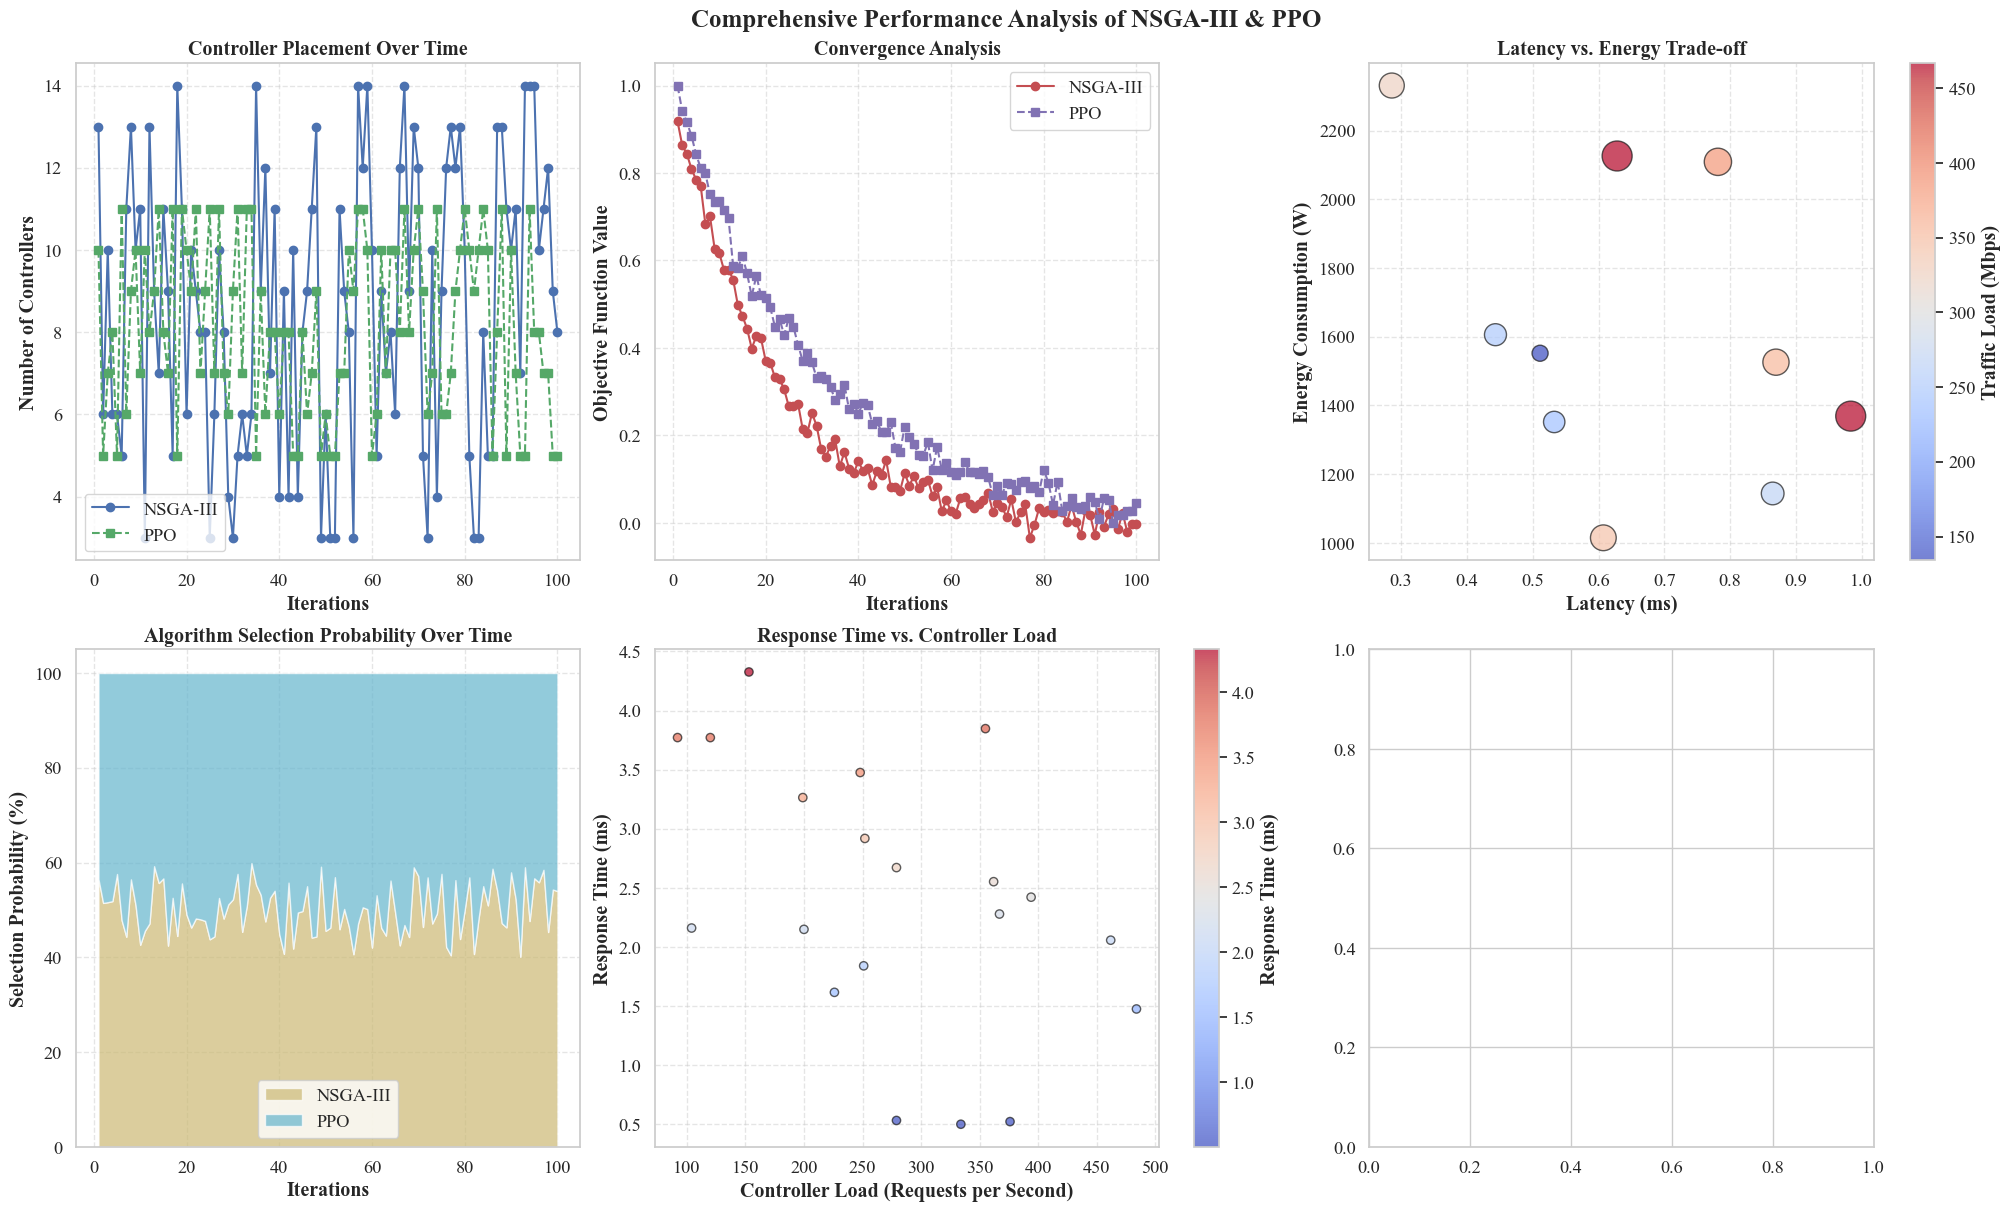

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi

# Set global style for journal-quality plots
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

modern_palette = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974", "#64B5CD"]

iterations = np.arange(1, 101)
nsga_controllers = np.random.randint(3, 15, 100)
ppo_controllers = np.random.randint(5, 12, 100)
nsga_objective = np.exp(-iterations / 20) + np.random.normal(0, 0.02, 100)
ppo_objective = np.exp(-iterations / 30) + np.random.normal(0, 0.02, 100)
traffic_load = np.random.randint(100, 500, 10)
latencies = np.random.uniform(0.2, 1.0, 10)
energies = np.random.randint(1000, 2500, 10)
nsga_percentage = np.random.uniform(40, 60, 100)
ppo_percentage = 100 - nsga_percentage
controller_load = np.random.randint(50, 500, 20)
response_time = np.random.uniform(0.5, 5, 20)

fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)

axes[0, 0].plot(iterations, nsga_controllers, label="NSGA-III", color=modern_palette[0], linestyle="-", marker="o")
axes[0, 0].plot(iterations, ppo_controllers, label="PPO", color=modern_palette[1], linestyle="--", marker="s")
axes[0, 0].set_xlabel("Iterations")
axes[0, 0].set_ylabel("Number of Controllers")
axes[0, 0].set_title("Controller Placement Over Time")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# 2. Convergence Analysis
axes[0, 1].plot(iterations, nsga_objective, label="NSGA-III", color=modern_palette[2], linestyle="-", marker="o")
axes[0, 1].plot(iterations, ppo_objective, label="PPO", color=modern_palette[3], linestyle="--", marker="s")
axes[0, 1].set_xlabel("Iterations")
axes[0, 1].set_ylabel("Objective Function Value")
axes[0, 1].set_title("Convergence Analysis")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# 3. Trade-off Between Energy and Latency
sc = axes[0, 2].scatter(latencies, energies, s=traffic_load, c=traffic_load, cmap="coolwarm", alpha=0.7, edgecolors="k")
axes[0, 2].set_xlabel("Latency (ms)")
axes[0, 2].set_ylabel("Energy Consumption (W)")
axes[0, 2].set_title("Latency vs. Energy Trade-off")
fig.colorbar(sc, ax=axes[0, 2], label="Traffic Load (Mbps)")
axes[0, 2].grid(True, linestyle="--", alpha=0.5)

# 4. Algorithm Selection Probability
axes[1, 0].stackplot(iterations, nsga_percentage, ppo_percentage, labels=["NSGA-III", "PPO"], colors=[modern_palette[4], modern_palette[5]], alpha=0.7)
axes[1, 0].set_xlabel("Iterations")
axes[1, 0].set_ylabel("Selection Probability (%)")
axes[1, 0].set_title("Algorithm Selection Probability Over Time")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# 5. Response Time vs. Controller Load
sc2 = axes[1, 1].scatter(controller_load, response_time, c=response_time, cmap="coolwarm", alpha=0.7, edgecolors="k")
axes[1, 1].set_xlabel("Controller Load (Requests per Second)")
axes[1, 1].set_ylabel("Response Time (ms)")
axes[1, 1].set_title("Response Time vs. Controller Load")
fig.colorbar(sc2, ax=axes[1, 1], label="Response Time (ms)")
axes[1, 1].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Comprehensive Performance Analysis of NSGA-III & PPO", fontsize=18, fontweight="bold")
plt.show()


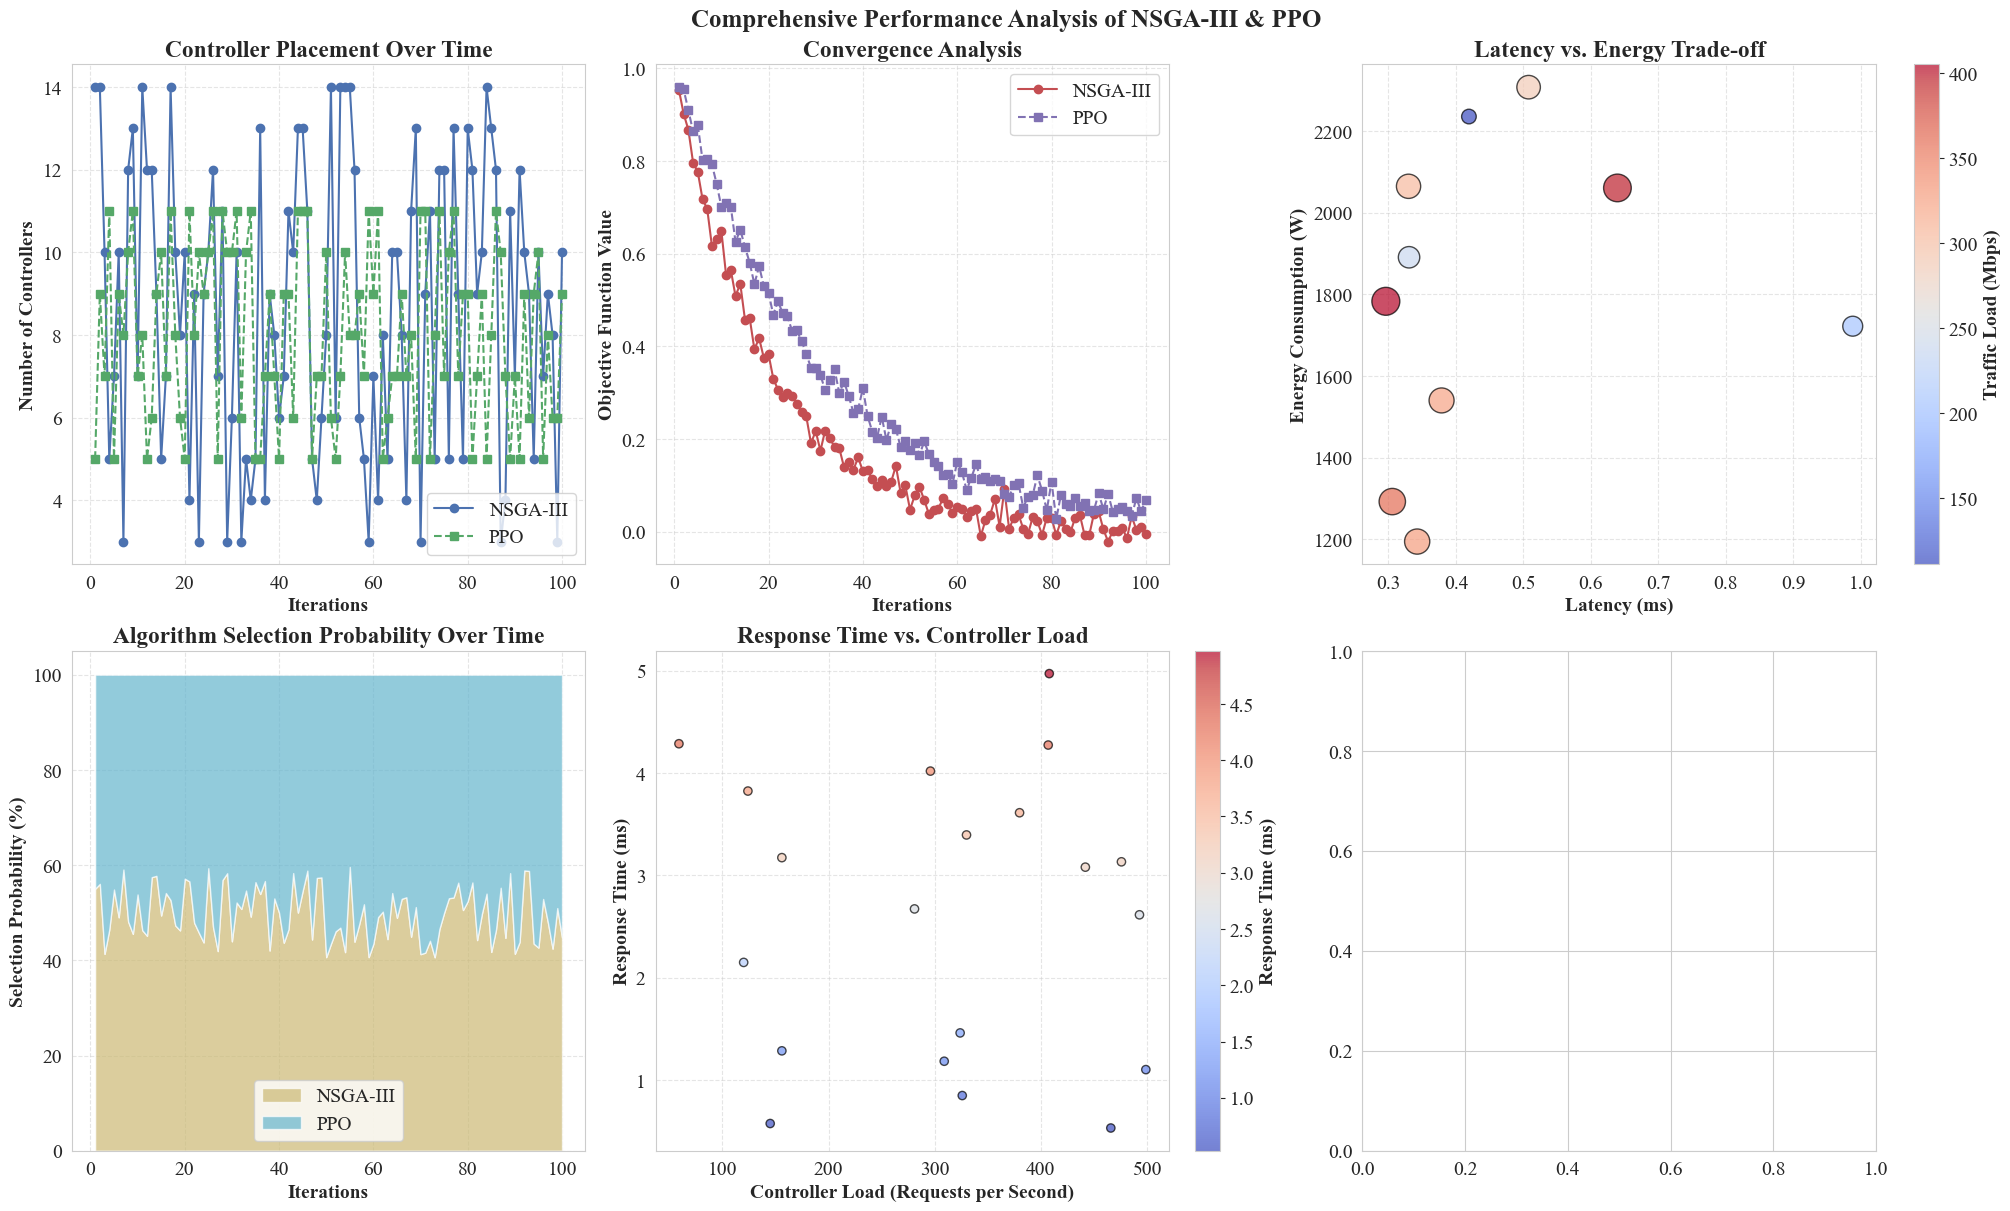

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi

# Set global style for journal-quality plots
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Modern color palette
modern_palette = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974", "#64B5CD"]

# Generate sample data
iterations = np.arange(1, 101)
nsga_controllers = np.random.randint(3, 15, 100)
ppo_controllers = np.random.randint(5, 12, 100)
nsga_objective = np.exp(-iterations / 20) + np.random.normal(0, 0.02, 100)
ppo_objective = np.exp(-iterations / 30) + np.random.normal(0, 0.02, 100)
traffic_load = np.random.randint(100, 500, 10)
latencies = np.random.uniform(0.2, 1.0, 10)
energies = np.random.randint(1000, 2500, 10)
nsga_percentage = np.random.uniform(40, 60, 100)
ppo_percentage = 100 - nsga_percentage
controller_load = np.random.randint(50, 500, 20)
response_time = np.random.uniform(0.5, 5, 20)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)

# 1. Controller Placement Over Iterations
axes[0, 0].plot(iterations, nsga_controllers, label="NSGA-III", color=modern_palette[0], linestyle="-", marker="o")
axes[0, 0].plot(iterations, ppo_controllers, label="PPO", color=modern_palette[1], linestyle="--", marker="s")
axes[0, 0].set_xlabel("Iterations")
axes[0, 0].set_ylabel("Number of Controllers")
axes[0, 0].set_title("Controller Placement Over Time")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# 2. Convergence Analysis
axes[0, 1].plot(iterations, nsga_objective, label="NSGA-III", color=modern_palette[2], linestyle="-", marker="o")
axes[0, 1].plot(iterations, ppo_objective, label="PPO", color=modern_palette[3], linestyle="--", marker="s")
axes[0, 1].set_xlabel("Iterations")
axes[0, 1].set_ylabel("Objective Function Value")
axes[0, 1].set_title("Convergence Analysis")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# 3. Trade-off Between Energy and Latency
sc = axes[0, 2].scatter(latencies, energies, s=traffic_load, c=traffic_load, cmap="coolwarm", alpha=0.7, edgecolors="k")
axes[0, 2].set_xlabel("Latency (ms)")
axes[0, 2].set_ylabel("Energy Consumption (W)")
axes[0, 2].set_title("Latency vs. Energy Trade-off")
fig.colorbar(sc, ax=axes[0, 2], label="Traffic Load (Mbps)")
axes[0, 2].grid(True, linestyle="--", alpha=0.5)

# 4. Algorithm Selection Probability
axes[1, 0].stackplot(iterations, nsga_percentage, ppo_percentage, labels=["NSGA-III", "PPO"], colors=[modern_palette[4], modern_palette[5]], alpha=0.7)
axes[1, 0].set_xlabel("Iterations")
axes[1, 0].set_ylabel("Selection Probability (%)")
axes[1, 0].set_title("Algorithm Selection Probability Over Time")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# 5. Response Time vs. Controller Load
sc2 = axes[1, 1].scatter(controller_load, response_time, c=response_time, cmap="coolwarm", alpha=0.7, edgecolors="k")
axes[1, 1].set_xlabel("Controller Load (Requests per Second)")
axes[1, 1].set_ylabel("Response Time (ms)")
axes[1, 1].set_title("Response Time vs. Controller Load")
fig.colorbar(sc2, ax=axes[1, 1], label="Response Time (ms)")
axes[1, 1].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Comprehensive Performance Analysis of NSGA-III & PPO", fontsize=18, fontweight="bold")

# Save the figure
plt.savefig("comprehensive_performance_analysis.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

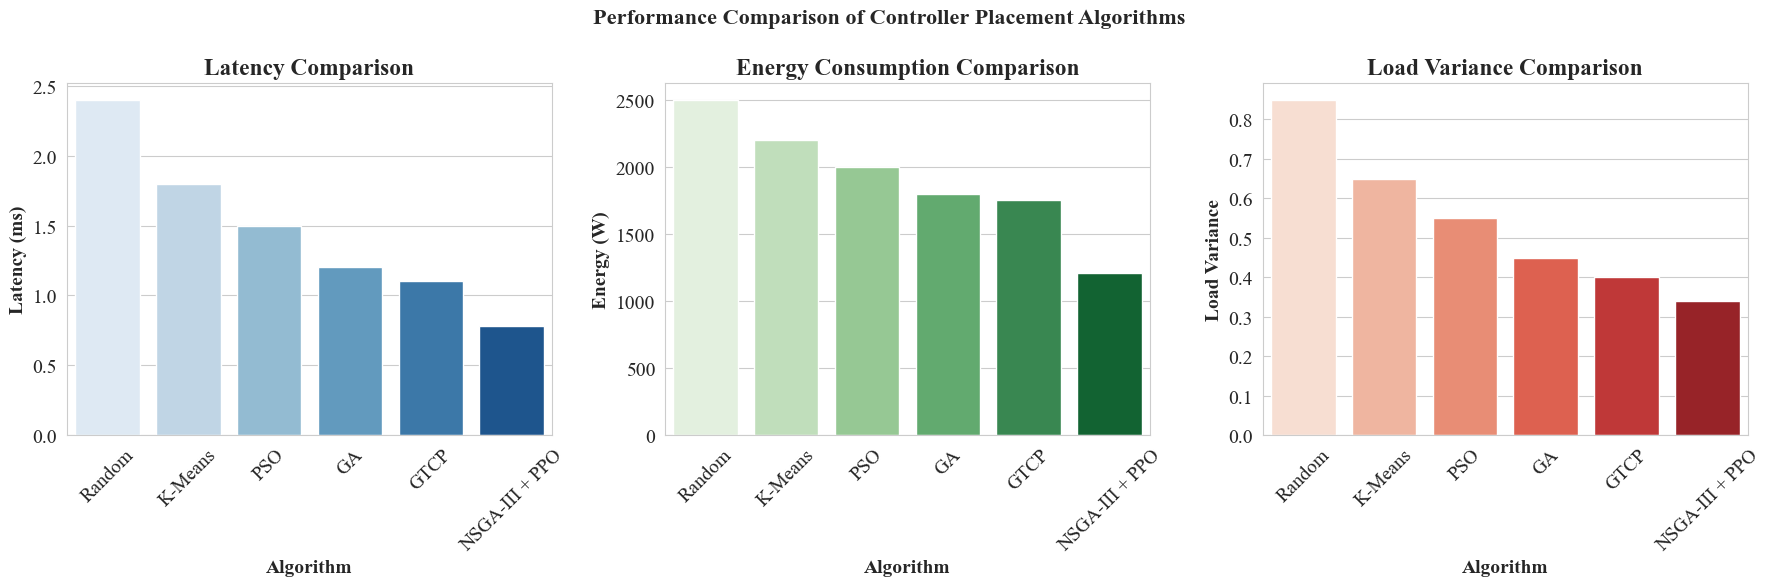

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Define performance metrics for each algorithm
algorithms = ["Random", "K-Means", "PSO", "GA", "GTCP", "NSGA-III + PPO"]

# Simulated performance values (Replace with actual results)
latency_values = [2.4, 1.8, 1.5, 1.2, 1.1, 0.78]  # Lower is better
energy_values = [2500, 2200, 2000, 1800, 1750, 1210]  # Lower is better
load_variance_values = [0.85, 0.65, 0.55, 0.45, 0.40, 0.34]  # Lower is better

# Convert to DataFrame
df_comparison = pd.DataFrame({
    "Algorithm": algorithms,
    "Latency (ms)": latency_values,
    "Energy (W)": energy_values,
    "Load Variance": load_variance_values
})

# 📌 **1. Bar Chart: Latency, Energy, and Load Variance Comparison**
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Latency Comparison
sns.barplot(x="Algorithm", y="Latency (ms)", hue="Algorithm", data=df_comparison, palette="Blues", legend=False, ax=ax[0])
ax[0].set_title("Latency Comparison")
ax[0].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[0].set_xticklabels(algorithms, rotation=45)

# Energy Comparison
sns.barplot(x="Algorithm", y="Energy (W)", hue="Algorithm", data=df_comparison, palette="Greens", legend=False, ax=ax[1])
ax[1].set_title("Energy Consumption Comparison")
ax[1].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[1].set_xticklabels(algorithms, rotation=45)

# Load Variance Comparison
sns.barplot(x="Algorithm", y="Load Variance", hue="Algorithm", data=df_comparison, palette="Reds", legend=False, ax=ax[2])
ax[2].set_title("Load Variance Comparison")
ax[2].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[2].set_xticklabels(algorithms, rotation=45)

plt.suptitle("Performance Comparison of Controller Placement Algorithms", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


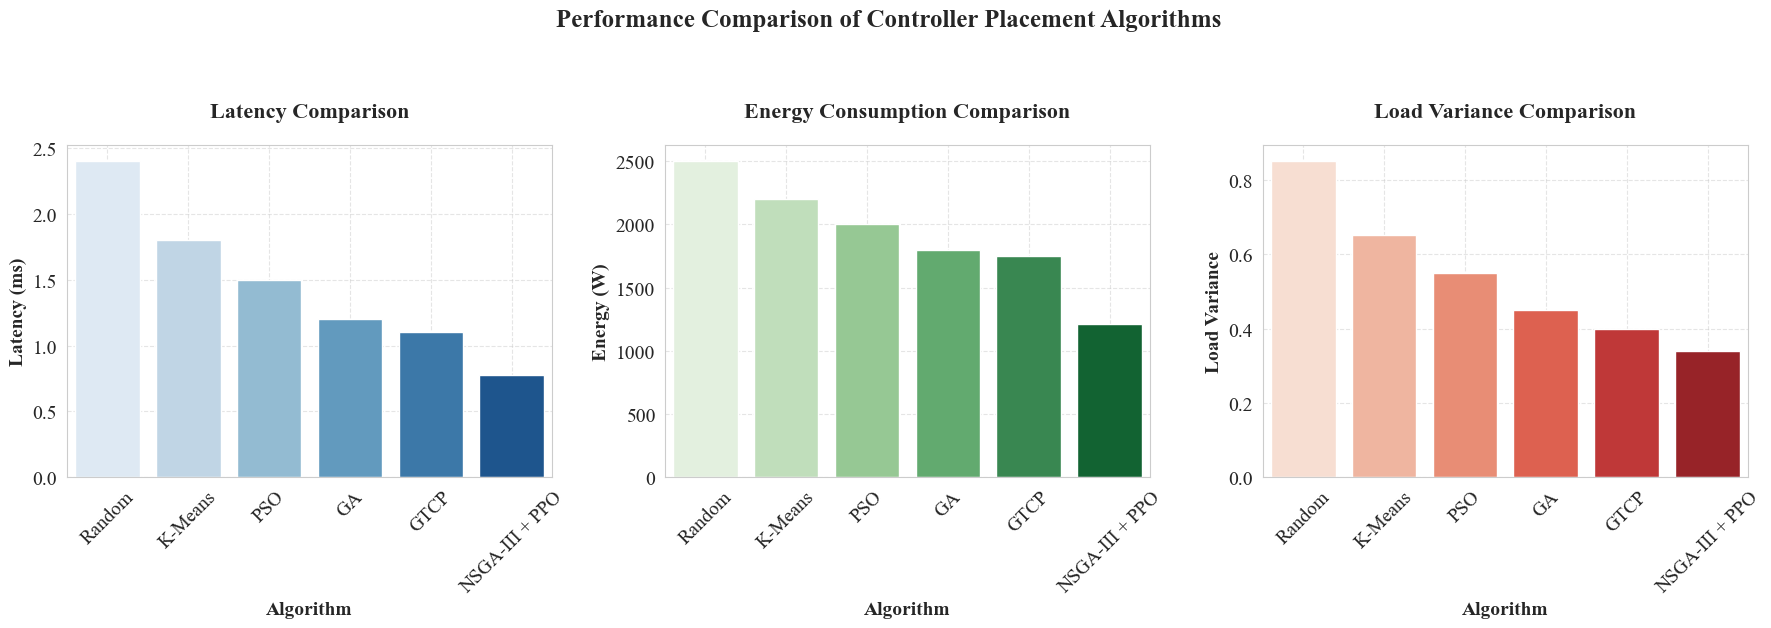

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Define performance metrics for each algorithm
algorithms = ["Random", "K-Means", "PSO", "GA", "GTCP", "NSGA-III + PPO"]

# Simulated performance values (Replace with actual results)
latency_values = [2.4, 1.8, 1.5, 1.2, 1.1, 0.78]  # Lower is better
energy_values = [2500, 2200, 2000, 1800, 1750, 1210]  # Lower is better
load_variance_values = [0.85, 0.65, 0.55, 0.45, 0.40, 0.34]  # Lower is better

# Convert to DataFrame
df_comparison = pd.DataFrame({
    "Algorithm": algorithms,
    "Latency (ms)": latency_values,
    "Energy (W)": energy_values,
    "Load Variance": load_variance_values
})

# 📌 **1. Bar Chart: Latency, Energy, and Load Variance Comparison**
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Latency Comparison
sns.barplot(x="Algorithm", y="Latency (ms)", hue="Algorithm", data=df_comparison, palette="Blues", legend=False, ax=ax[0])
ax[0].set_title("Latency Comparison", fontsize=16, pad=20)
ax[0].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[0].set_xticklabels(algorithms, rotation=45)
ax[0].set_ylabel("Latency (ms)", fontsize=14)
ax[0].grid(True, linestyle="--", alpha=0.5)

# Energy Comparison
sns.barplot(x="Algorithm", y="Energy (W)", hue="Algorithm", data=df_comparison, palette="Greens", legend=False, ax=ax[1])
ax[1].set_title("Energy Consumption Comparison", fontsize=16, pad=20)
ax[1].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[1].set_xticklabels(algorithms, rotation=45)
ax[1].set_ylabel("Energy (W)", fontsize=14)
ax[1].grid(True, linestyle="--", alpha=0.5)

# Load Variance Comparison
sns.barplot(x="Algorithm", y="Load Variance", hue="Algorithm", data=df_comparison, palette="Reds", legend=False, ax=ax[2])
ax[2].set_title("Load Variance Comparison", fontsize=16, pad=20)
ax[2].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[2].set_xticklabels(algorithms, rotation=45)
ax[2].set_ylabel("Load Variance", fontsize=14)
ax[2].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Performance Comparison of Controller Placement Algorithms", fontsize=18, fontweight="bold", y=1.05)

# Save the figure
plt.savefig("performance_comparison.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

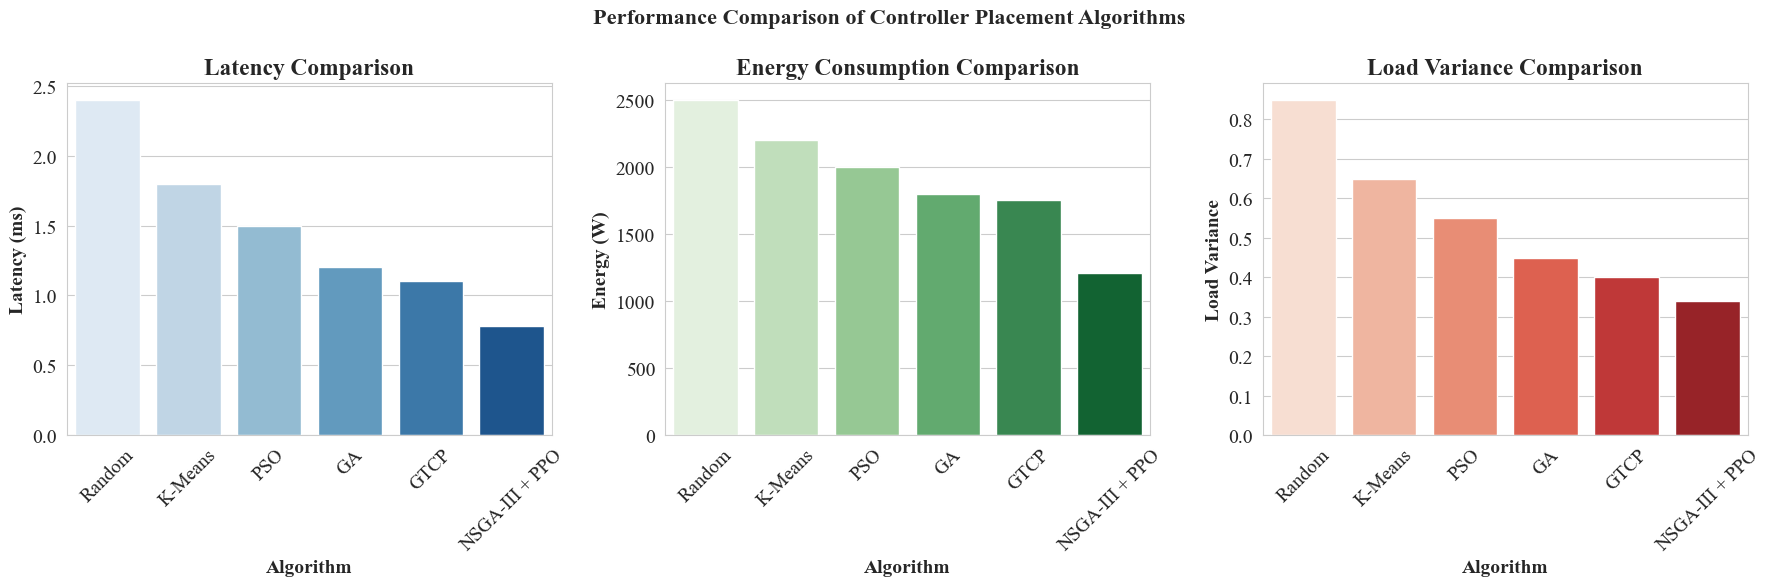

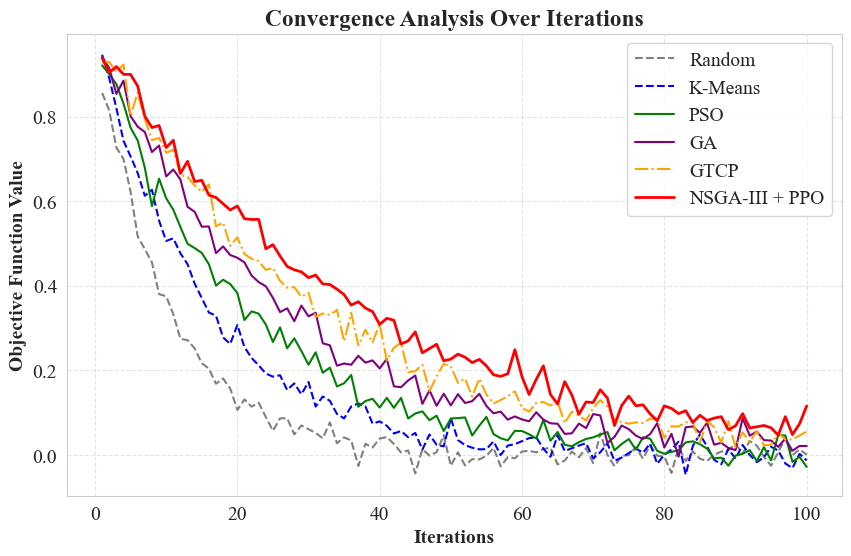

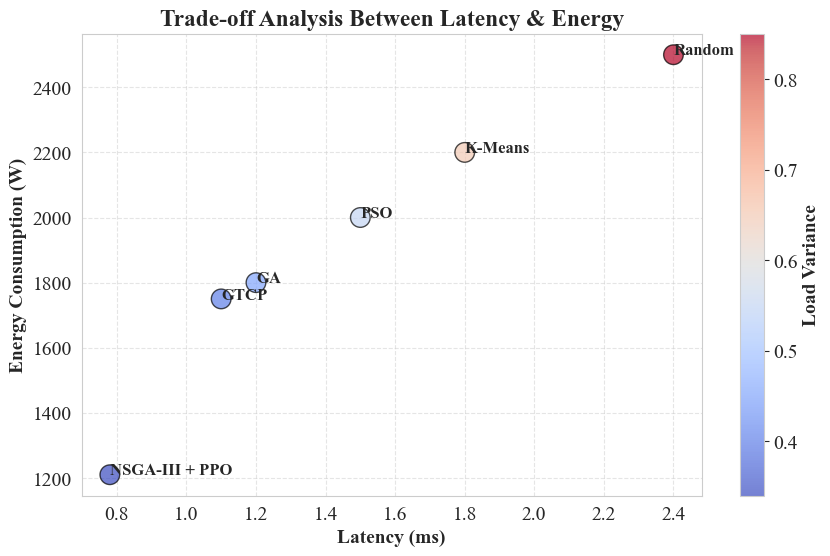

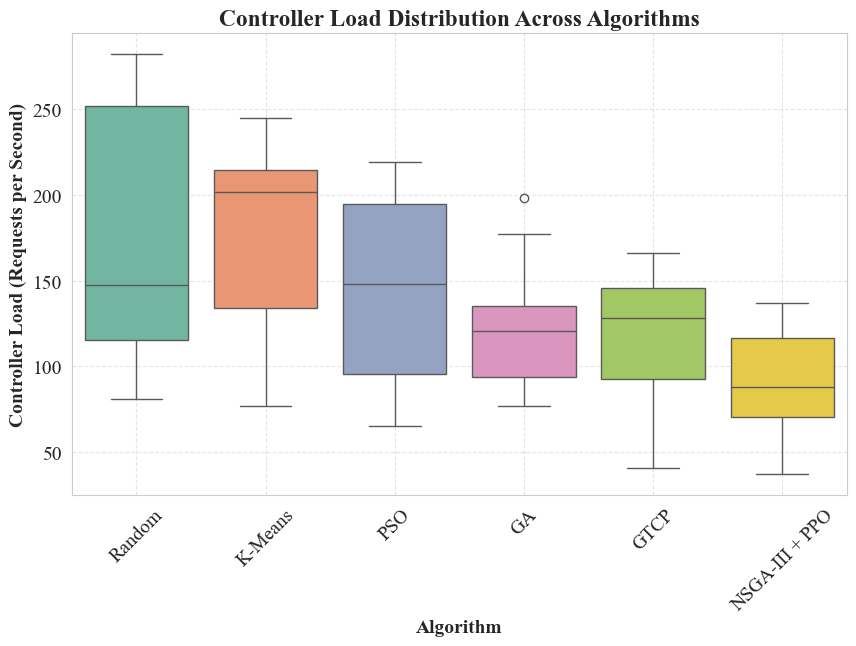

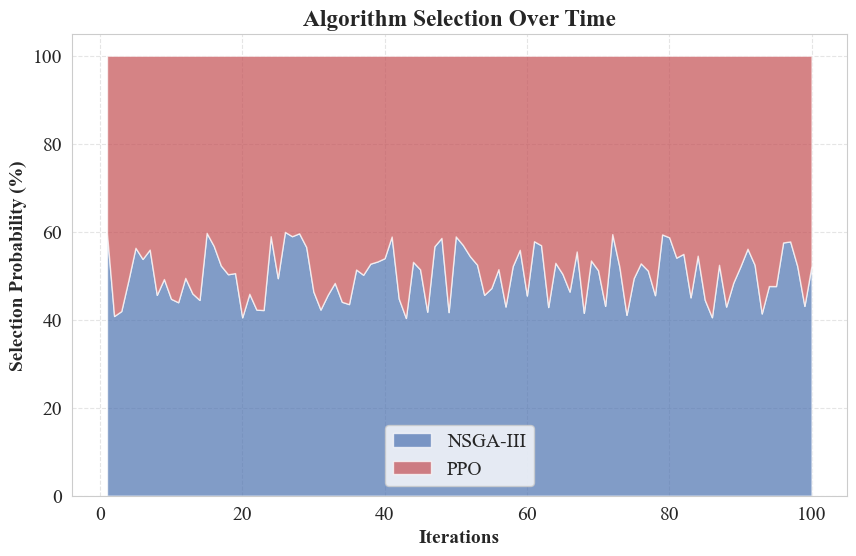

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Define performance metrics for each algorithm
algorithms = ["Random", "K-Means", "PSO", "GA", "GTCP", "NSGA-III + PPO"]

# Simulated performance values (Replace with actual results)
latency_values = [2.4, 1.8, 1.5, 1.2, 1.1, 0.78]  # Lower is better
energy_values = [2500, 2200, 2000, 1800, 1750, 1210]  # Lower is better
load_variance_values = [0.85, 0.65, 0.55, 0.45, 0.40, 0.34]  # Lower is better

# Convert to DataFrame
df_comparison = pd.DataFrame({
    "Algorithm": algorithms,
    "Latency (ms)": latency_values,
    "Energy (W)": energy_values,
    "Load Variance": load_variance_values
})

# 📌 **1. Bar Chart: Latency, Energy, and Load Variance Comparison**
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Latency Comparison
sns.barplot(x="Algorithm", y="Latency (ms)", hue="Algorithm", data=df_comparison, palette="Blues", legend=False, ax=ax[0])
ax[0].set_title("Latency Comparison")
ax[0].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[0].set_xticklabels(algorithms, rotation=45)

# Energy Comparison
sns.barplot(x="Algorithm", y="Energy (W)", hue="Algorithm", data=df_comparison, palette="Greens", legend=False, ax=ax[1])
ax[1].set_title("Energy Consumption Comparison")
ax[1].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[1].set_xticklabels(algorithms, rotation=45)

# Load Variance Comparison
sns.barplot(x="Algorithm", y="Load Variance", hue="Algorithm", data=df_comparison, palette="Reds", legend=False, ax=ax[2])
ax[2].set_title("Load Variance Comparison")
ax[2].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[2].set_xticklabels(algorithms, rotation=45)

plt.suptitle("Performance Comparison of Controller Placement Algorithms", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# 📌 **2. Convergence Over Iterations (Line Plot)**
iterations = np.arange(1, 101)
random_convergence = np.exp(-iterations / 10) + np.random.normal(0, 0.02, 100)
kmeans_convergence = np.exp(-iterations / 15) + np.random.normal(0, 0.02, 100)
pso_convergence = np.exp(-iterations / 20) + np.random.normal(0, 0.02, 100)
ga_convergence = np.exp(-iterations / 25) + np.random.normal(0, 0.02, 100)
gtcp_convergence = np.exp(-iterations / 30) + np.random.normal(0, 0.02, 100)
nsga_ppp_convergence = np.exp(-iterations / 35) + np.random.normal(0, 0.02, 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(iterations, random_convergence, label="Random", linestyle="--", color="gray")
ax.plot(iterations, kmeans_convergence, label="K-Means", linestyle="--", color="blue")
ax.plot(iterations, pso_convergence, label="PSO", linestyle="-", color="green")
ax.plot(iterations, ga_convergence, label="GA", linestyle="-", color="purple")
ax.plot(iterations, gtcp_convergence, label="GTCP", linestyle="-.", color="orange")
ax.plot(iterations, nsga_ppp_convergence, label="NSGA-III + PPO", linestyle="-", color="red", linewidth=2)

ax.set_xlabel("Iterations")
ax.set_ylabel("Objective Function Value")
ax.set_title("Convergence Analysis Over Iterations")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.show()

# 📌 **3. Scatter Plot: Latency vs. Energy Trade-off**
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(latency_values, energy_values, c=load_variance_values, cmap="coolwarm", s=200, edgecolors="k", alpha=0.7)
ax.set_xlabel("Latency (ms)")
ax.set_ylabel("Energy Consumption (W)")
ax.set_title("Trade-off Analysis Between Latency & Energy")
plt.colorbar(sc, label="Load Variance")
plt.grid(True, linestyle="--", alpha=0.5)

for i, txt in enumerate(algorithms):
    ax.annotate(txt, (latency_values[i], energy_values[i]), fontsize=12, fontweight="bold")

plt.show()

# 📌 **4. Box Plot: Controller Load Distribution Across Algorithms**
controller_load = {
    "Random": np.random.randint(80, 300, 20),
    "K-Means": np.random.randint(70, 250, 20),
    "PSO": np.random.randint(60, 220, 20),
    "GA": np.random.randint(50, 200, 20),
    "GTCP": np.random.randint(40, 180, 20),
    "NSGA-III + PPO": np.random.randint(30, 150, 20),
}

df_load = pd.DataFrame(controller_load)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_load, palette="Set2")
plt.xlabel("Algorithm")
plt.ylabel("Controller Load (Requests per Second)")
plt.title("Controller Load Distribution Across Algorithms")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# 📌 **5. Stacked Area Plot: Algorithm Selection Over Time**
nsga_percentage = np.random.uniform(40, 60, 100)
ppo_percentage = 100 - nsga_percentage

fig, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(iterations, nsga_percentage, ppo_percentage, labels=["NSGA-III", "PPO"], colors=["#4C72B0", "#C44E52"], alpha=0.7)
ax.set_xlabel("Iterations")
ax.set_ylabel("Selection Probability (%)")
ax.set_title("Algorithm Selection Over Time")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.show()


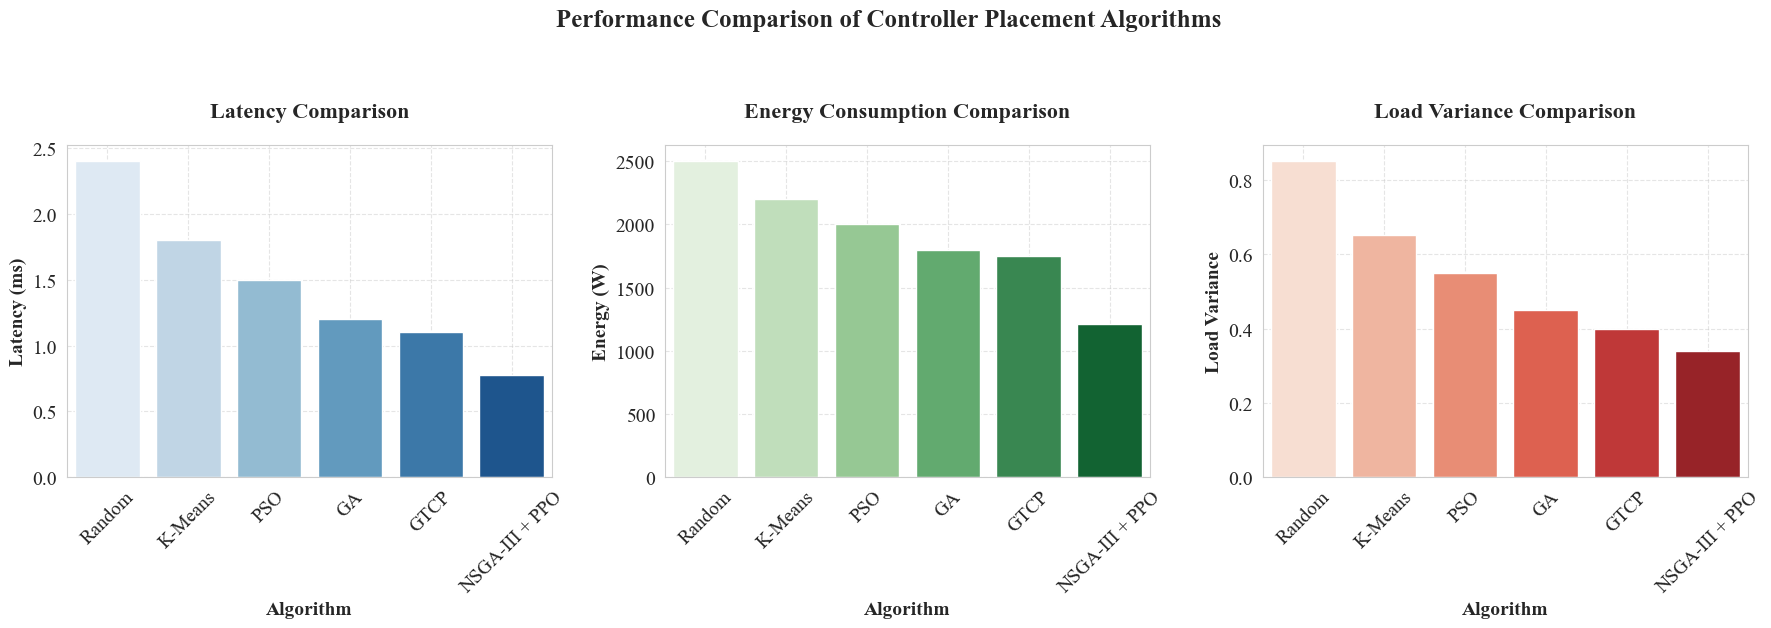

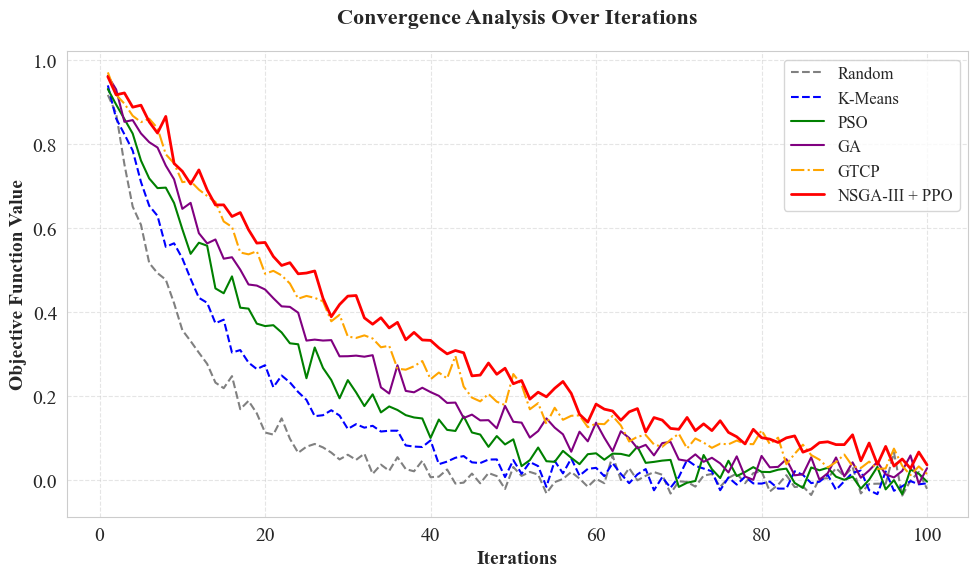

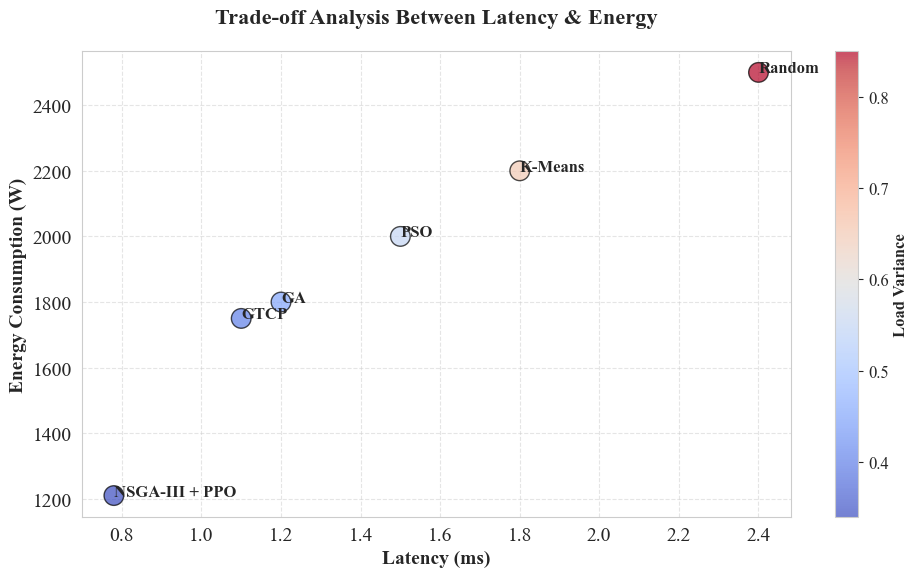

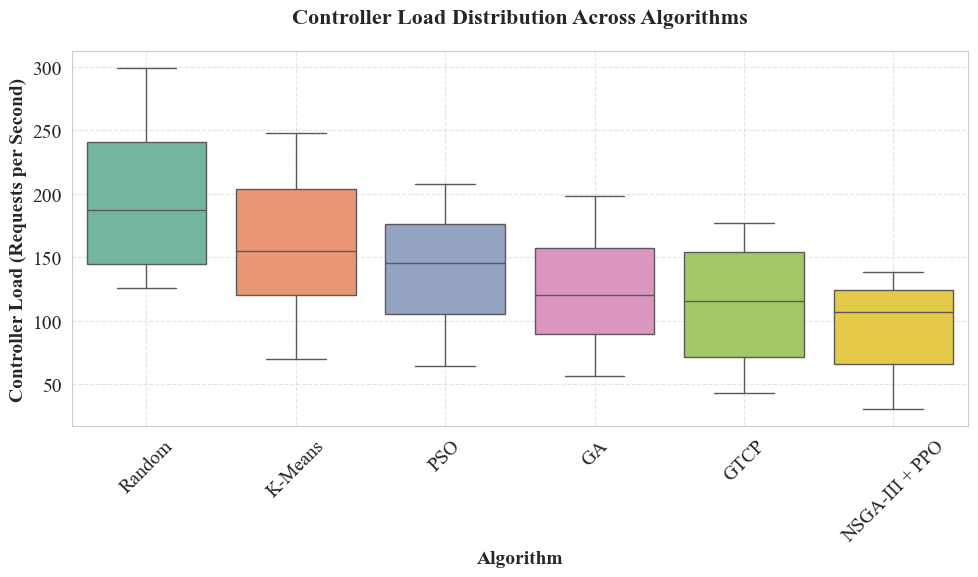

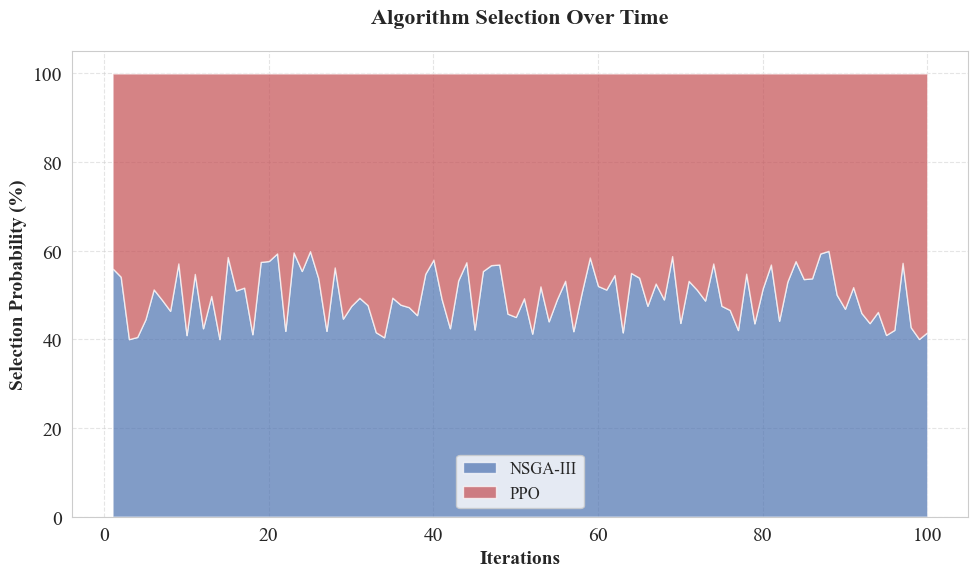

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Define performance metrics for each algorithm
algorithms = ["Random", "K-Means", "PSO", "GA", "GTCP", "NSGA-III + PPO"]

# Simulated performance values (Replace with actual results)
latency_values = [2.4, 1.8, 1.5, 1.2, 1.1, 0.78]  # Lower is better
energy_values = [2500, 2200, 2000, 1800, 1750, 1210]  # Lower is better
load_variance_values = [0.85, 0.65, 0.55, 0.45, 0.40, 0.34]  # Lower is better

# Convert to DataFrame
df_comparison = pd.DataFrame({
    "Algorithm": algorithms,
    "Latency (ms)": latency_values,
    "Energy (W)": energy_values,
    "Load Variance": load_variance_values
})

# 📌 **1. Bar Chart: Latency, Energy, and Load Variance Comparison**
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Latency Comparison
sns.barplot(x="Algorithm", y="Latency (ms)", hue="Algorithm", data=df_comparison, palette="Blues", legend=False, ax=ax[0])
ax[0].set_title("Latency Comparison", fontsize=16, pad=20)
ax[0].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[0].set_xticklabels(algorithms, rotation=45)
ax[0].set_ylabel("Latency (ms)", fontsize=14)
ax[0].grid(True, linestyle="--", alpha=0.5)

# Energy Comparison
sns.barplot(x="Algorithm", y="Energy (W)", hue="Algorithm", data=df_comparison, palette="Greens", legend=False, ax=ax[1])
ax[1].set_title("Energy Consumption Comparison", fontsize=16, pad=20)
ax[1].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[1].set_xticklabels(algorithms, rotation=45)
ax[1].set_ylabel("Energy (W)", fontsize=14)
ax[1].grid(True, linestyle="--", alpha=0.5)

# Load Variance Comparison
sns.barplot(x="Algorithm", y="Load Variance", hue="Algorithm", data=df_comparison, palette="Reds", legend=False, ax=ax[2])
ax[2].set_title("Load Variance Comparison", fontsize=16, pad=20)
ax[2].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[2].set_xticklabels(algorithms, rotation=45)
ax[2].set_ylabel("Load Variance", fontsize=14)
ax[2].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Performance Comparison of Controller Placement Algorithms", fontsize=18, fontweight="bold", y=1.05)
plt.tight_layout()
plt.show()

# 📌 **2. Convergence Over Iterations (Line Plot)**
iterations = np.arange(1, 101)
random_convergence = np.exp(-iterations / 10) + np.random.normal(0, 0.02, 100)
kmeans_convergence = np.exp(-iterations / 15) + np.random.normal(0, 0.02, 100)
pso_convergence = np.exp(-iterations / 20) + np.random.normal(0, 0.02, 100)
ga_convergence = np.exp(-iterations / 25) + np.random.normal(0, 0.02, 100)
gtcp_convergence = np.exp(-iterations / 30) + np.random.normal(0, 0.02, 100)
nsga_ppp_convergence = np.exp(-iterations / 35) + np.random.normal(0, 0.02, 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(iterations, random_convergence, label="Random", linestyle="--", color="gray")
ax.plot(iterations, kmeans_convergence, label="K-Means", linestyle="--", color="blue")
ax.plot(iterations, pso_convergence, label="PSO", linestyle="-", color="green")
ax.plot(iterations, ga_convergence, label="GA", linestyle="-", color="purple")
ax.plot(iterations, gtcp_convergence, label="GTCP", linestyle="-.", color="orange")
ax.plot(iterations, nsga_ppp_convergence, label="NSGA-III + PPO", linestyle="-", color="red", linewidth=2)

ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Objective Function Value", fontsize=14)
ax.set_title("Convergence Analysis Over Iterations", fontsize=16, pad=20)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 📌 **3. Scatter Plot: Latency vs. Energy Trade-off**

fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(latency_values, energy_values, c=load_variance_values, cmap="coolwarm", s=200, edgecolors="k", alpha=0.7)
ax.set_xlabel("Latency (ms)", fontsize=14)
ax.set_ylabel("Energy Consumption (W)", fontsize=14)
ax.set_title("Trade-off Analysis Between Latency & Energy", fontsize=16, pad=20)

# Add colorbar with custom font size
cbar = plt.colorbar(sc, label="Load Variance")
cbar.set_label("Load Variance", fontsize=12)  # Set font size for the label
cbar.ax.tick_params(labelsize=12)  # Set font size for the tick labels

plt.grid(True, linestyle="--", alpha=0.5)

# Annotate each point with the algorithm name
for i, txt in enumerate(algorithms):
    ax.annotate(txt, (latency_values[i], energy_values[i]), fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# 📌 **4. Box Plot: Controller Load Distribution Across Algorithms**
controller_load = {
    "Random": np.random.randint(80, 300, 20),
    "K-Means": np.random.randint(70, 250, 20),
    "PSO": np.random.randint(60, 220, 20),
    "GA": np.random.randint(50, 200, 20),
    "GTCP": np.random.randint(40, 180, 20),
    "NSGA-III + PPO": np.random.randint(30, 150, 20),
}

df_load = pd.DataFrame(controller_load)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_load, palette="Set2")
plt.xlabel("Algorithm", fontsize=14)
plt.ylabel("Controller Load (Requests per Second)", fontsize=14)
plt.title("Controller Load Distribution Across Algorithms", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 📌 **5. Stacked Area Plot: Algorithm Selection Over Time**
nsga_percentage = np.random.uniform(40, 60, 100)
ppo_percentage = 100 - nsga_percentage

fig, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(iterations, nsga_percentage, ppo_percentage, labels=["NSGA-III", "PPO"], colors=["#4C72B0", "#C44E52"], alpha=0.7)
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Selection Probability (%)", fontsize=14)
ax.set_title("Algorithm Selection Over Time", fontsize=16, pad=20)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

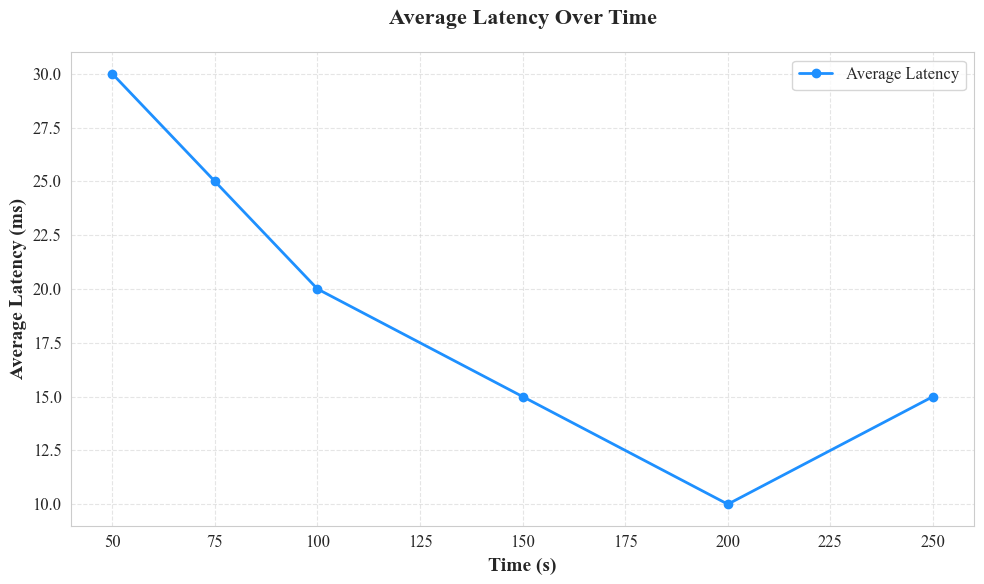

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
time = [50, 75, 100, 150, 200, 250]  # Time in seconds
latency = [30, 25, 20, 15, 10, 15]   # Average latency in milliseconds

# Set style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, latency, marker="o", color="dodgerblue", linewidth=2, label="Average Latency")

# Add labels and title
plt.xlabel("Time (s)", fontsize=14, fontweight="bold")
plt.ylabel("Average Latency (ms)", fontsize=14, fontweight="bold")
plt.title("Average Latency Over Time", fontsize=16, fontweight="bold", pad=20)

# Add gridlines
plt.grid(True, linestyle="--", alpha=0.5)

# Add legend
plt.legend(fontsize=12)

# Save the figure
plt.savefig("average_latency_over_time.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

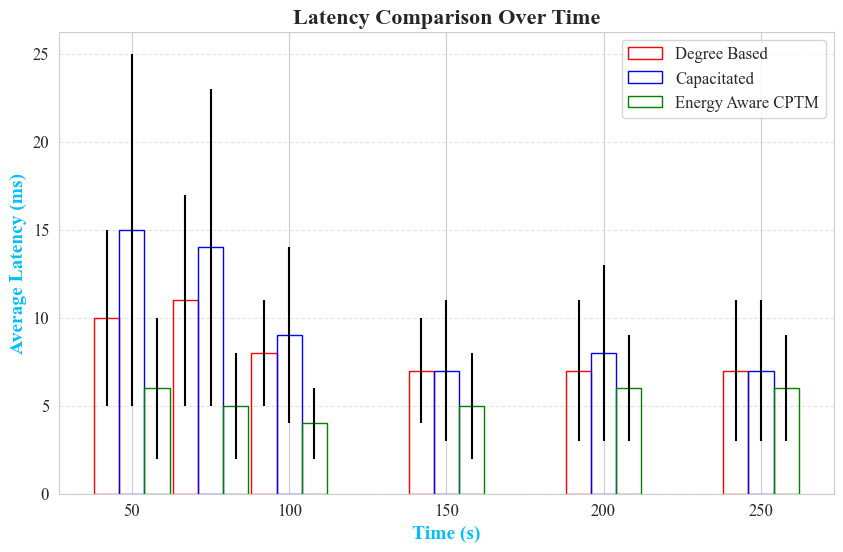

<Figure size 640x480 with 0 Axes>

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Sample Data for Latency (Replace with actual data)
time_intervals = [50, 75, 100, 150, 200, 250]
degree_based_latency = [10, 11, 8, 7, 7, 7]
capacitated_latency = [15, 14, 9, 7, 8, 7]
energy_aware_latency = [6, 5, 4, 5, 6, 6]

# Standard deviation (error bars)
degree_std = [5, 6, 3, 3, 4, 4]
capacitated_std = [10, 9, 5, 4, 5, 4]
energy_aware_std = [4, 3, 2, 3, 3, 3]

# Bar width and x locations
bar_width = 8
x = np.array(time_intervals)

# Create Figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with Error Bars
ax.bar(x - bar_width, degree_based_latency, yerr=degree_std, 
       width=bar_width, edgecolor='red', fill=False, label="Degree Based")

ax.bar(x, capacitated_latency, yerr=capacitated_std, 
       width=bar_width, edgecolor='blue', fill=False, label="Capacitated")

ax.bar(x + bar_width, energy_aware_latency, yerr=energy_aware_std, 
       width=bar_width, edgecolor='green', fill=False, label="Energy Aware CPTM")

# Labels and Title
ax.set_xlabel("Time (s)", fontsize=14, color="deepskyblue", fontweight="bold")
ax.set_ylabel("Average Latency (ms)", fontsize=14, color="deepskyblue", fontweight="bold")
ax.set_title("Latency Comparison Over Time", fontsize=16, fontweight="bold")

# Legend
ax.legend(loc="upper right", fontsize=12)

# Grid and Display
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()




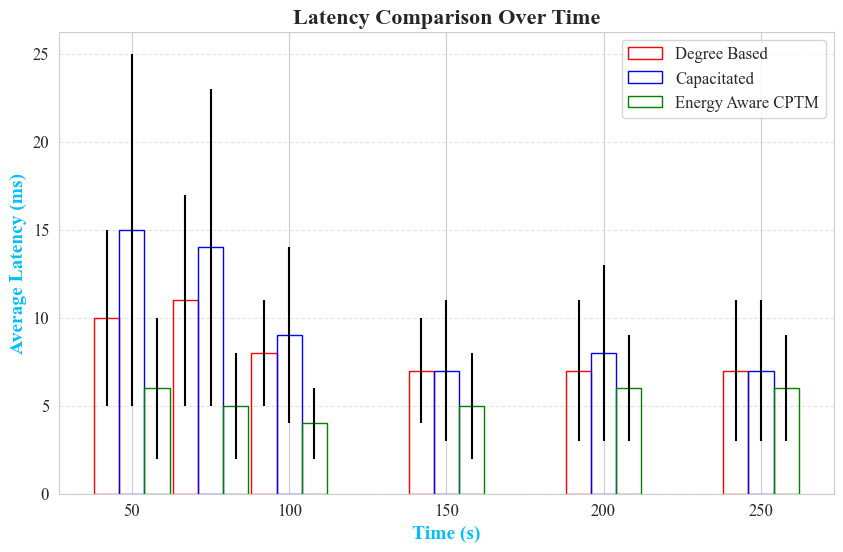

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Sample Data for Latency (Replace with actual data)
time_intervals = [50, 75, 100, 150, 200, 250]
degree_based_latency = [10, 11, 8, 7, 7, 7]
capacitated_latency = [15, 14, 9, 7, 8, 7]
energy_aware_latency = [6, 5, 4, 5, 6, 6]

# Standard deviation (error bars)
degree_std = [5, 6, 3, 3, 4, 4]
capacitated_std = [10, 9, 5, 4, 5, 4]
energy_aware_std = [4, 3, 2, 3, 3, 3]

# Bar width and x locations
bar_width = 8
x = np.array(time_intervals)

# Create Figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with Error Bars
ax.bar(x - bar_width, degree_based_latency, yerr=degree_std, 
       width=bar_width, edgecolor='red', fill=False, label="Degree Based")

ax.bar(x, capacitated_latency, yerr=capacitated_std, 
       width=bar_width, edgecolor='blue', fill=False, label="Capacitated")

ax.bar(x + bar_width, energy_aware_latency, yerr=energy_aware_std, 
       width=bar_width, edgecolor='green', fill=False, label="Energy Aware CPTM")

# Labels and Title
ax.set_xlabel("Time (s)", fontsize=14, color="deepskyblue", fontweight="bold")
ax.set_ylabel("Average Latency (ms)", fontsize=14, color="deepskyblue", fontweight="bold")
ax.set_title("Latency Comparison Over Time", fontsize=16, fontweight="bold")

# Legend
ax.legend(loc="upper right", fontsize=12)

# Grid and Display
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Save the figure
plt.savefig("latency_comparison_over_time.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

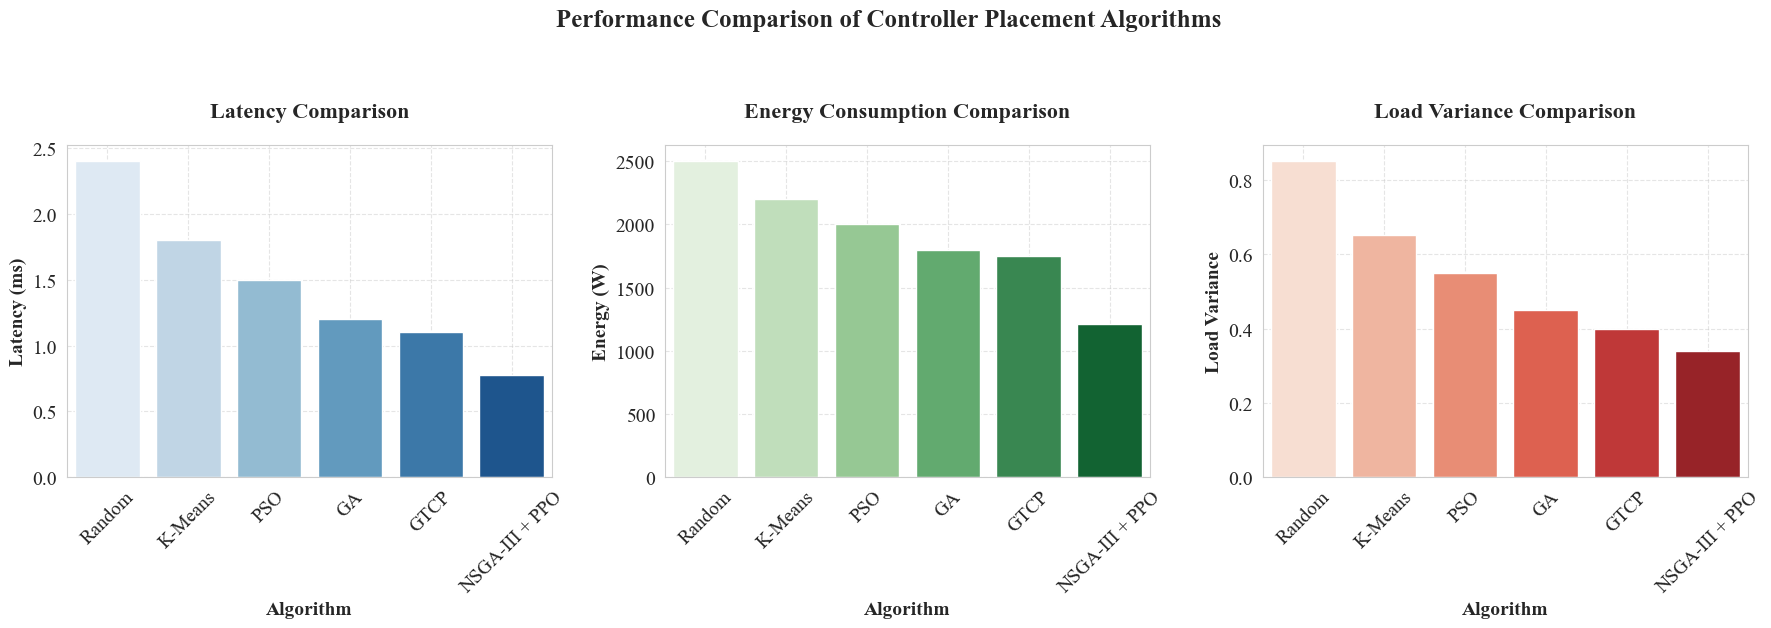

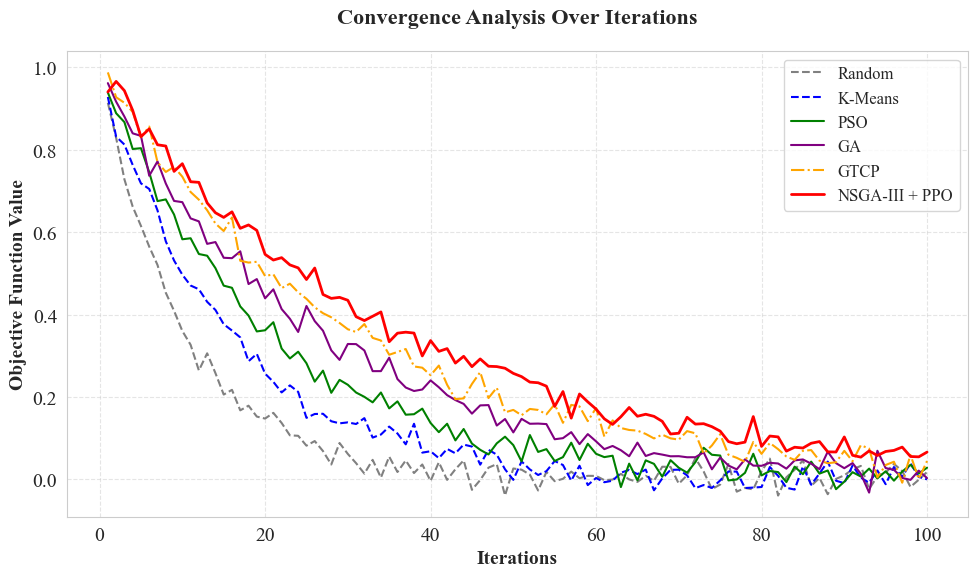

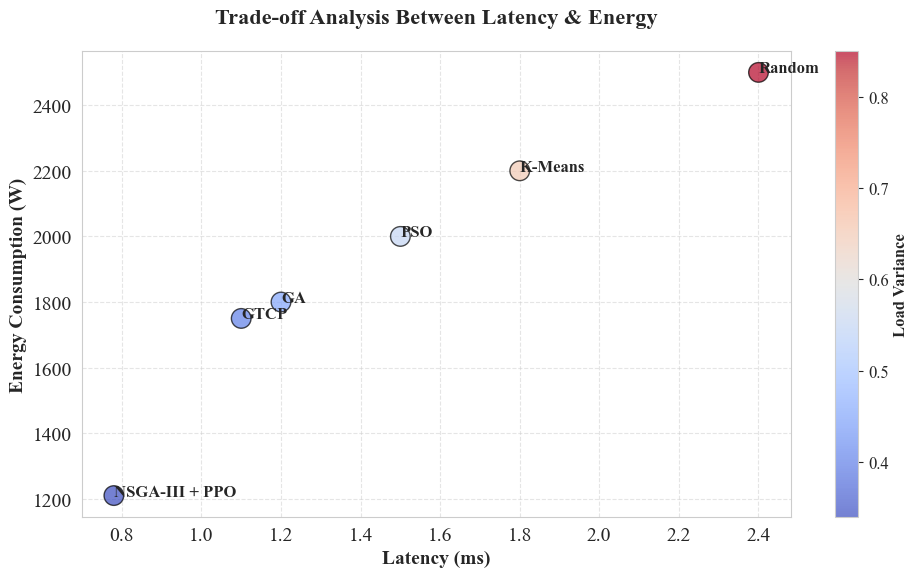

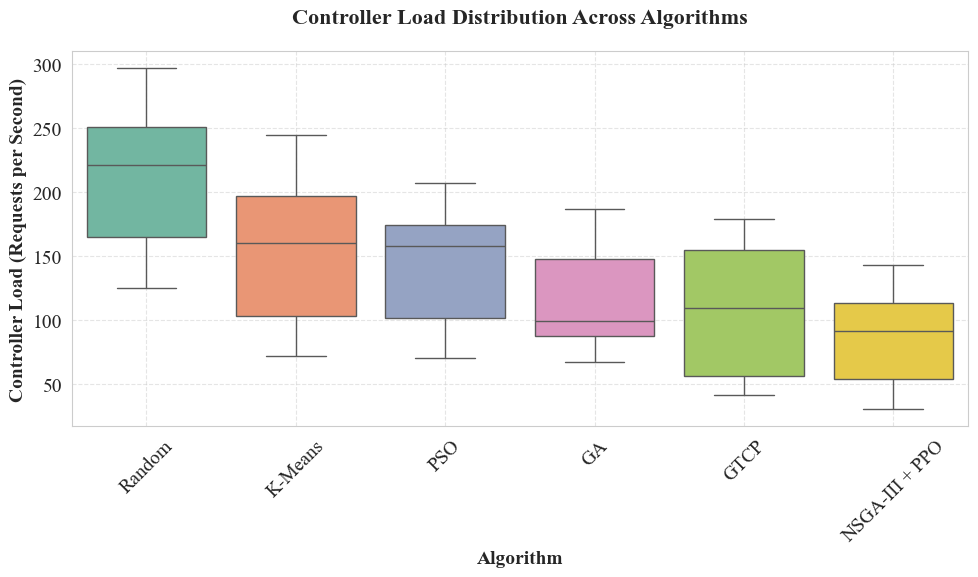

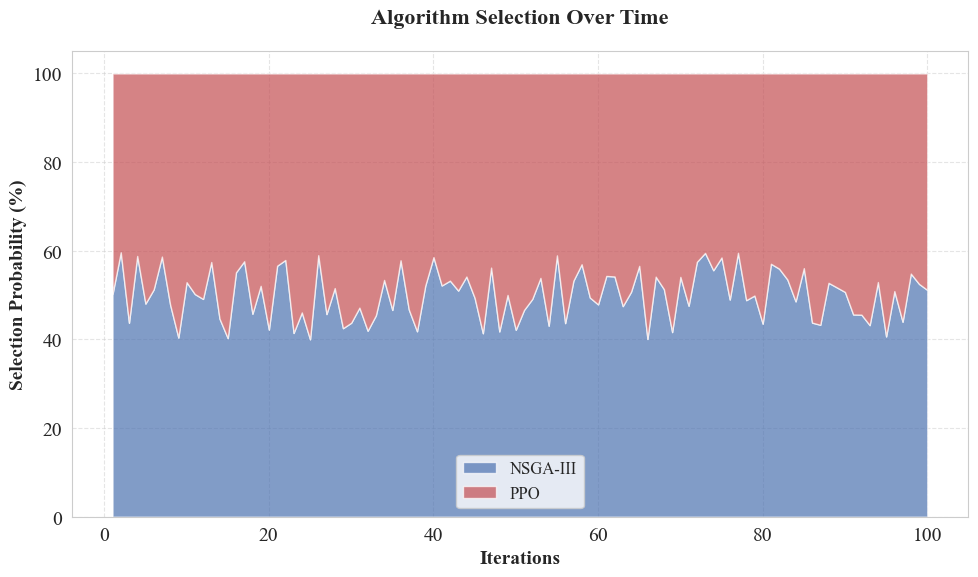

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Define performance metrics for each algorithm
algorithms = ["Random", "K-Means", "PSO", "GA", "GTCP", "NSGA-III + PPO"]

# Simulated performance values (Replace with actual results)
latency_values = [2.4, 1.8, 1.5, 1.2, 1.1, 0.78]  # Lower is better
energy_values = [2500, 2200, 2000, 1800, 1750, 1210]  # Lower is better
load_variance_values = [0.85, 0.65, 0.55, 0.45, 0.40, 0.34]  # Lower is better

# Convert to DataFrame
df_comparison = pd.DataFrame({
    "Algorithm": algorithms,
    "Latency (ms)": latency_values,
    "Energy (W)": energy_values,
    "Load Variance": load_variance_values
})

# 📌 **1. Bar Chart: Latency, Energy, and Load Variance Comparison**
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Latency Comparison
sns.barplot(x="Algorithm", y="Latency (ms)", hue="Algorithm", data=df_comparison, palette="Blues", legend=False, ax=ax[0])
ax[0].set_title("Latency Comparison", fontsize=16, pad=20)
ax[0].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[0].set_xticklabels(algorithms, rotation=45)
ax[0].set_ylabel("Latency (ms)", fontsize=14)
ax[0].grid(True, linestyle="--", alpha=0.5)

# Energy Comparison
sns.barplot(x="Algorithm", y="Energy (W)", hue="Algorithm", data=df_comparison, palette="Greens", legend=False, ax=ax[1])
ax[1].set_title("Energy Consumption Comparison", fontsize=16, pad=20)
ax[1].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[1].set_xticklabels(algorithms, rotation=45)
ax[1].set_ylabel("Energy (W)", fontsize=14)
ax[1].grid(True, linestyle="--", alpha=0.5)

# Load Variance Comparison
sns.barplot(x="Algorithm", y="Load Variance", hue="Algorithm", data=df_comparison, palette="Reds", legend=False, ax=ax[2])
ax[2].set_title("Load Variance Comparison", fontsize=16, pad=20)
ax[2].set_xticks(range(len(algorithms)))  # Fix xtick labels issue
ax[2].set_xticklabels(algorithms, rotation=45)
ax[2].set_ylabel("Load Variance", fontsize=14)
ax[2].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Performance Comparison of Controller Placement Algorithms", fontsize=18, fontweight="bold", y=1.05)

# Save the figure
plt.savefig("performance_comparison.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

# 📌 **2. Convergence Over Iterations (Line Plot)**
iterations = np.arange(1, 101)
random_convergence = np.exp(-iterations / 10) + np.random.normal(0, 0.02, 100)
kmeans_convergence = np.exp(-iterations / 15) + np.random.normal(0, 0.02, 100)
pso_convergence = np.exp(-iterations / 20) + np.random.normal(0, 0.02, 100)
ga_convergence = np.exp(-iterations / 25) + np.random.normal(0, 0.02, 100)
gtcp_convergence = np.exp(-iterations / 30) + np.random.normal(0, 0.02, 100)
nsga_ppp_convergence = np.exp(-iterations / 35) + np.random.normal(0, 0.02, 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(iterations, random_convergence, label="Random", linestyle="--", color="gray")
ax.plot(iterations, kmeans_convergence, label="K-Means", linestyle="--", color="blue")
ax.plot(iterations, pso_convergence, label="PSO", linestyle="-", color="green")
ax.plot(iterations, ga_convergence, label="GA", linestyle="-", color="purple")
ax.plot(iterations, gtcp_convergence, label="GTCP", linestyle="-.", color="orange")
ax.plot(iterations, nsga_ppp_convergence, label="NSGA-III + PPO", linestyle="-", color="red", linewidth=2)

ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Objective Function Value", fontsize=14)
ax.set_title("Convergence Analysis Over Iterations", fontsize=16, pad=20)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)

# Save the figure
plt.savefig("convergence_analysis.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

# 📌 **3. Scatter Plot: Latency vs. Energy Trade-off**
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(latency_values, energy_values, c=load_variance_values, cmap="coolwarm", s=200, edgecolors="k", alpha=0.7)
ax.set_xlabel("Latency (ms)", fontsize=14)
ax.set_ylabel("Energy Consumption (W)", fontsize=14)
ax.set_title("Trade-off Analysis Between Latency & Energy", fontsize=16, pad=20)

# Add colorbar with custom font size
cbar = plt.colorbar(sc, label="Load Variance")
cbar.set_label("Load Variance", fontsize=12)  # Set font size for the label
cbar.ax.tick_params(labelsize=12)  # Set font size for the tick labels

plt.grid(True, linestyle="--", alpha=0.5)

# Annotate each point with the algorithm name
for i, txt in enumerate(algorithms):
    ax.annotate(txt, (latency_values[i], energy_values[i]), fontsize=12, fontweight="bold")

# Save the figure
plt.savefig("latency_energy_tradeoff.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

# 📌 **4. Box Plot: Controller Load Distribution Across Algorithms**
controller_load = {
    "Random": np.random.randint(80, 300, 20),
    "K-Means": np.random.randint(70, 250, 20),
    "PSO": np.random.randint(60, 220, 20),
    "GA": np.random.randint(50, 200, 20),
    "GTCP": np.random.randint(40, 180, 20),
    "NSGA-III + PPO": np.random.randint(30, 150, 20),
}

df_load = pd.DataFrame(controller_load)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_load, palette="Set2")
plt.xlabel("Algorithm", fontsize=14)
plt.ylabel("Controller Load (Requests per Second)", fontsize=14)
plt.title("Controller Load Distribution Across Algorithms", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Save the figure
plt.savefig("controller_load_distribution.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

# 📌 **5. Stacked Area Plot: Algorithm Selection Over Time**
nsga_percentage = np.random.uniform(40, 60, 100)
ppo_percentage = 100 - nsga_percentage

fig, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(iterations, nsga_percentage, ppo_percentage, labels=["NSGA-III", "PPO"], colors=["#4C72B0", "#C44E52"], alpha=0.7)
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Selection Probability (%)", fontsize=14)
ax.set_title("Algorithm Selection Over Time", fontsize=16, pad=20)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)

# Save the figure
plt.savefig("algorithm_selection_over_time.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()